# Exploratory Data Analysis for Data Science and Machine Learning 
### IBM Guided Project

## Importing Required Libraries

In [3]:
import random
import missingno as msno
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_context('notebook') # Configures the aesthetics of the plots for jupyter notebook
sns.set_style('white') # Sets background style of plots to white

import matplotlib.pyplot as plt
%matplotlib inline 
# ensures that inline plotting works correctly (newer versions of jypyter notbook does not need this)

from scipy.stats import shapiro

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.datasets import load_diabetes, load_iris
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from fasteda import fast_eda

## Regression
The aim is to predict a numeric score indicating diabetes progression one year after bloor pressure, BMI and bloor sugar level are recorder using Regression. 

## Load the diabetes data set (from sklearn)

In [6]:
# About the data
print(load_diabetes()['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [7]:
# Load the data from sklearn as two pandas.DataFrame - features (X) and target variable (y)
diabetes_X, diabetes_y = load_diabetes(return_X_y = True, as_frame = True, scaled = False)

#Renaming columns
diabetes_X.columns= ['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']

In [8]:
diabetes_X.head()

age  sex   bmi     bp     tc    ldl   hdl  tch     ltg   glu
0  59.0  2.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0
1  48.0  1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0
2  72.0  2.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0
3  24.0  1.0  25.3   84.0  198.0  131.4  40.0  5.0  4.8903  89.0
4  50.0  1.0  23.0  101.0  192.0  125.4  52.0  4.0  4.2905  80.0

In [9]:
diabetes_y.head()

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64

In [10]:
# Combine both diabetes_X (features) and diabetes_y (target) into one pandas.DataFrame
diabetes = pd.concat([diabetes_X, pd.Series(diabetes_y)], axis=1)

#Renaming the column with target value
diabetes.rename(columns={0: 'target'}, inplace=True)

In [11]:
# Looking into the data
diabetes.sample(5)

age  sex   bmi      bp     tc    ldl   hdl   tch     ltg    glu  target
392  37.0  2.0  23.6   94.00  205.0  138.8  53.0  4.00  4.1897  107.0   118.0
58   60.0  1.0  20.4  105.00  198.0   78.4  99.0  2.00  4.6347   79.0   170.0
229  41.0  2.0  24.9   86.00  192.0  115.0  61.0  3.00  4.3820   94.0    53.0
177  62.0  1.0  28.9   87.33  206.0  127.2  33.0  6.24  5.4337   99.0   225.0
13   50.0  2.0  26.2   97.00  186.0  105.4  49.0  4.00  5.0626   88.0   185.0

## Add some missing values
The original dataset does not contain any missing value hence for the sake of EDA missing values are introduced to 3 columns and 5% of the rows at random

In [13]:
# Verifying that the data set has no missing values
diabetes.isna().max(axis=0).max()

False

In [14]:
# Intializing seed value to 2000 to make sure that the random value is same each time the code is executed
random.seed(2024)

# Selecting 3 columns at random
missing_cols = random.sample(range(len(diabetes.columns)), 3)

# Selecting 5% of row index at random
missing_rows = random.sample(diabetes.index.tolist(), int(np.round(len(diabetes.index.tolist())/20)))

# Setting missing values to the randomly selected rows and columns
diabetes.iloc[missing_rows, missing_cols] = np.nan

In [15]:
# Having a look at the columns which has been selected in random
print(diabetes.columns[missing_cols])

Index(['tch', 'bmi', 'tc'], dtype='object')


In [16]:
# Now verifying that the data set has missing values
diabetes.isna().max(axis=0).max()

True

## Initial Data Preprocessing
Note: In a typical workflow data preprocessing comes after conducting EDA

## One-Hot Encoding
In diabetes dataset `sex` is encoded as 1 and 2 for female and male, this is not ideal for predictive models as it may consided that the column has some ordering to it. Hence we use One-Hot encoding to create two different columns for each category of `sex` with binary values in it.

In [19]:
# Initializing OneHotEncoder (ignore unknown categories in dataset, no categories are dropped)
enc1 = OneHotEncoder(handle_unknown='ignore', drop=None)

# One-hot encode 'sex'. 
# Double square brackets are used to ensure that the extracted sex data is in DataFrame format which is required by One-hot encoder
# The output from OneHotEncoder is sparse matrix (stores only non-zero elements to save memory) which is converted to numpy array
encoded_sex = enc1.fit_transform(diabetes[['sex']]).toarray()

# Convert numpy array to pandas DataFrame with column names corresponding to its sex category 
encoded_sex = pd.DataFrame(encoded_sex, columns=['sex' + str(int(x)) for x in enc1.categories_[0]])

# Horrizontally concatenate dataframes'diabetes' and 'encoded_sex'
diabetes = pd.concat([diabetes, encoded_sex], axis=1)

# Looking into the modified diabetes DataFrame
diabetes.sample(5)

age  sex   bmi     bp     tc    ldl   hdl  tch     ltg   glu  target  \
282  68.0  1.0  25.9   93.0  253.0  181.2  53.0  5.0  4.5433  98.0   230.0   
162  34.0  1.0  29.2   73.0  172.0  108.2  49.0  4.0  4.3041  91.0   172.0   
144  57.0  2.0  30.7   90.0  204.0  147.8  34.0  6.0  4.7095  93.0   174.0   
270  50.0  2.0  29.2  119.0  162.0   85.2  54.0  3.0  4.7362  95.0   202.0   
404  44.0  1.0  31.4  115.0  165.0   97.6  52.0  3.0  4.3438  89.0   293.0   

     sex1  sex2  
282   1.0   0.0  
162   1.0   0.0  
144   0.0   1.0  
270   0.0   1.0  
404   1.0   0.0

From above sex is indicated through `sex`, `sex1` and `sex2`, two of which is redundant hence `sex` and `sex2` can be dropped 

In [21]:
# Drop 'sex' and 'sex2' from diabetes DataFrame
diabetes = diabetes.drop(['sex', 'sex2'], axis=1)

# Rename 'sex1' to 'sex'
diabetes = diabetes.rename(columns={'sex1': 'sex'})

# Reorder renamed 'sex' to the previous 'sex' position
diabetes = diabetes.loc[:, ['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu', 'target']]

# Looking into a sample of the modified diabetes DataFrame
diabetes.sample(5)

age  sex   bmi     bp     tc    ldl   hdl   tch     ltg    glu  target
224  41.0  1.0  20.2  62.00  153.0   89.0  50.0  3.00  4.2485   89.0    77.0
299  59.0  0.0  25.1  90.00  163.0  101.4  46.0  4.00  4.3567   91.0    83.0
200  64.0  1.0  21.0  92.33  227.0  146.8  65.0  3.49  4.3307  102.0   158.0
393  28.0  1.0  22.1  82.00  168.0  100.6  54.0  3.00  4.2047   86.0    69.0
25   30.0  0.0  25.2  83.00  178.0  118.4  34.0  5.00  4.8520   83.0   202.0

## Make a Train-Test Split
Below code will randomly assign 33% of the rows to test set and the remaining 67% to training set.
Training set is used to train the predictive models and the test set is the unseen data on which predictions are made.

In [23]:
# Make a Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    diabetes.iloc[:,:-1], # Features data (all columns except the last)
    diabetes.iloc[:,-1], # Target data (last column)
    test_size=0.33, # 33% for testing
    random_state=2024 # for reproducibility
)

# `X_train` are the feature columns in the training set.
# `X_test` are the feature columns in the test set.
# `y_train` is the target column for the training set.
# `y_test` is the target column for the test set.

## Perform EDA

### A look at the beginning and end of the data set

In [26]:
diabetes.head()

age  sex   bmi     bp     tc    ldl   hdl  tch     ltg   glu  target
0  59.0  0.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0   151.0
1  48.0  1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0    75.0
2  72.0  0.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0   141.0
3  24.0  1.0  25.3   84.0  198.0  131.4  40.0  5.0  4.8903  89.0   206.0
4  50.0  1.0  23.0  101.0  192.0  125.4  52.0  4.0  4.2905  80.0   135.0

In [27]:
diabetes.tail()

age  sex   bmi      bp     tc    ldl   hdl   tch     ltg    glu  target
437  60.0  0.0  28.2  112.00  185.0  113.8  42.0  4.00  4.9836   93.0   178.0
438  47.0  0.0  24.9   75.00  225.0  166.0  42.0  5.00  4.4427  102.0   104.0
439  60.0  0.0  24.9   99.67  162.0  106.6  43.0  3.77  4.1271   95.0   132.0
440  36.0  1.0  30.0   95.00  201.0  125.2  42.0  4.79  5.1299   85.0   220.0
441  36.0  1.0  19.6   71.00  250.0  133.2  97.0  3.00  4.5951   92.0    57.0

### Describe the DataFrame

In [29]:
# Having a look at the general statistical summaries for the diabetes DataFrame
diabetes.describe()

age         sex         bmi          bp          tc         ldl  \
count  442.000000  442.000000  420.000000  442.000000  420.000000  442.000000   
mean    48.518100    0.531674   26.358095   94.647014  188.830952  115.439140   
std     13.109028    0.499561    4.404820   13.831283   34.690827   30.413081   
min     19.000000    0.000000   18.000000   62.000000   97.000000   41.600000   
25%     38.250000    0.000000   23.175000   84.000000  164.000000   96.050000   
50%     50.000000    1.000000   25.700000   93.000000  186.000000  113.000000   
75%     59.000000    1.000000   29.325000  105.000000  209.000000  134.500000   
max     79.000000    1.000000   42.200000  133.000000  301.000000  242.400000   

              hdl         tch         ltg         glu      target  
count  442.000000  420.000000  442.000000  442.000000  442.000000  
mean    49.788462    4.071595    4.641411   91.260181  152.133484  
std     12.934202    1.296942    0.522391   11.496335   77.093005  
min     22.000000    2.000000    3.258100   58.000000   25.000000  
25%     40.250000    3.000000    4.276700   83.250000   87.000000  
50%     48.000000    4.000000    4.620050   91.000000  140.500000  
75%     57.750000    5.000000    4.997200   98.000000  211.500000  
max     99.000000    9.090000    6.107000  124.000000  346.000000

### Missing Values

In [31]:
# We know that the dataframe has missing values which can be verified below
diabetes.isna().max(axis=1).max()

True

In [32]:
# To see the summary of missing values in each column
diabetes.isna().sum()

age        0
sex        0
bmi       22
bp         0
tc        22
ldl        0
hdl        0
tch       22
ltg        0
glu        0
target     0
dtype: int64

<Axes: >

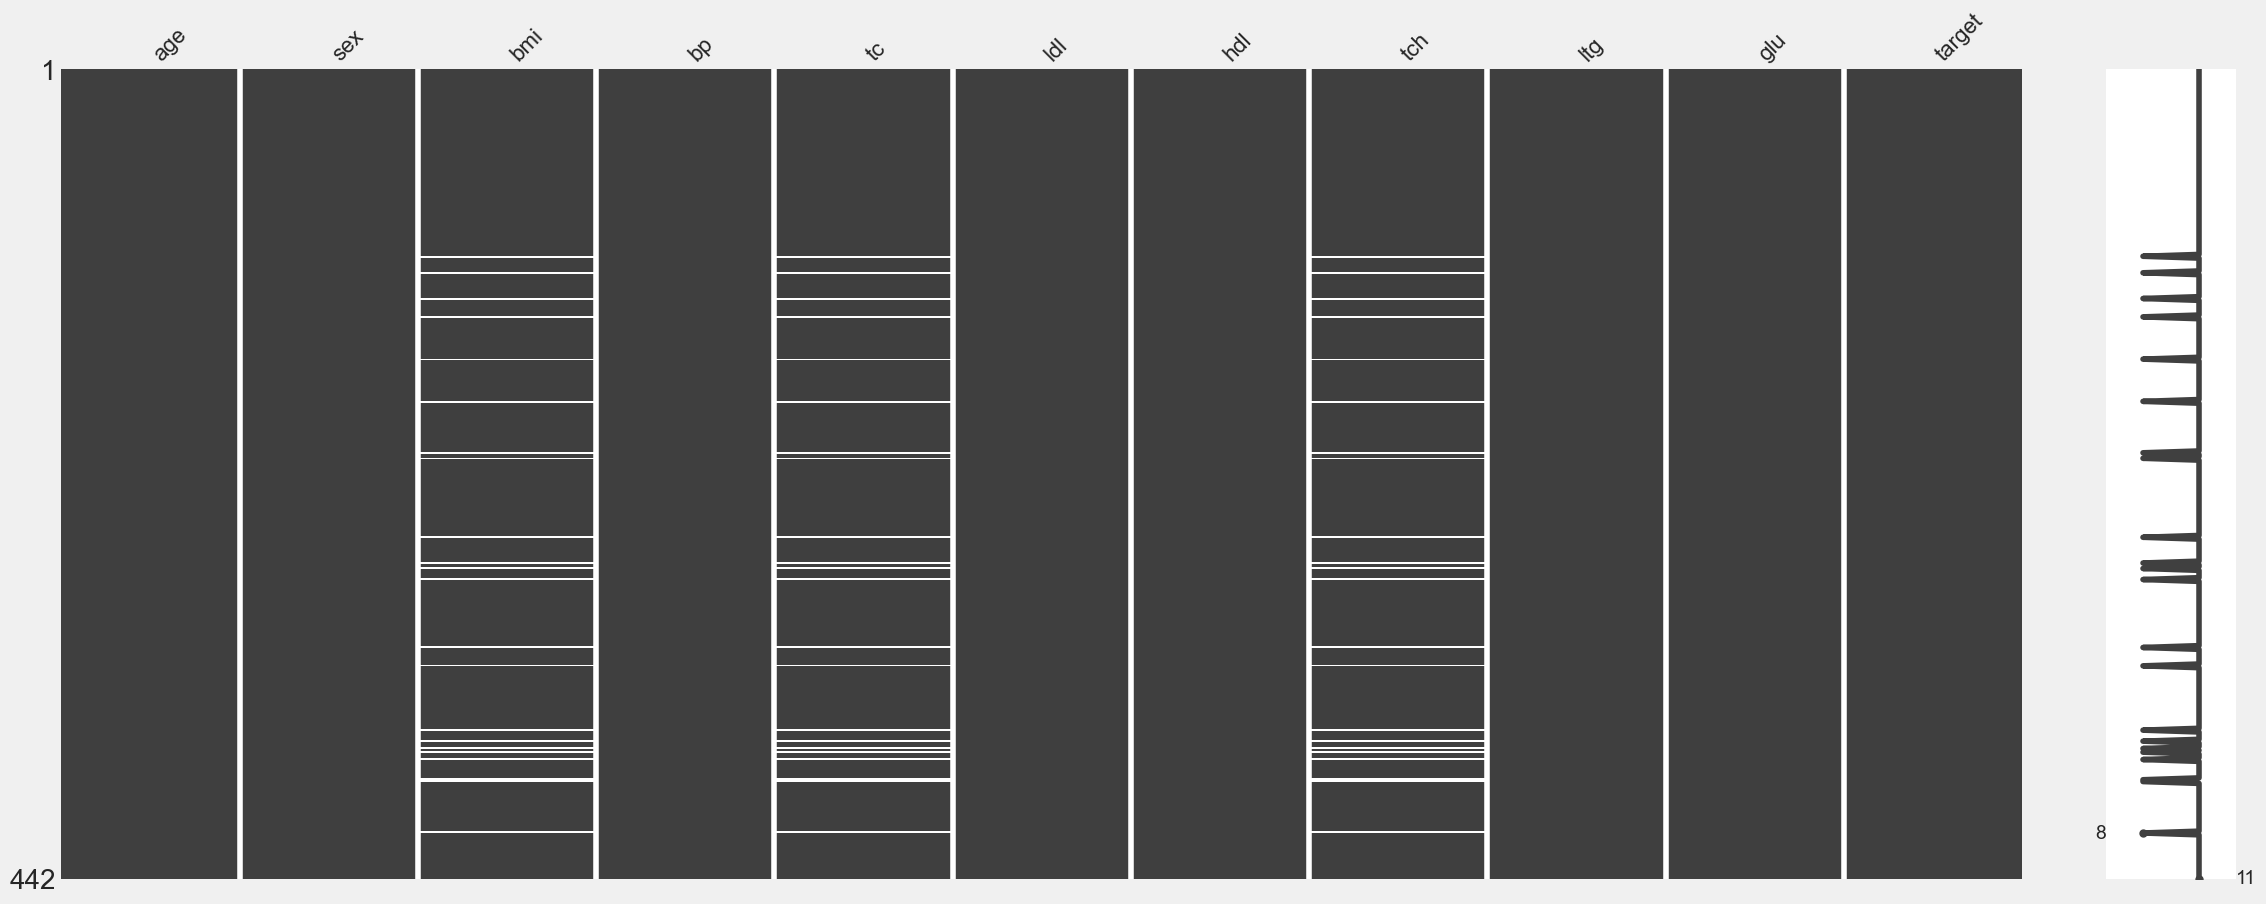

In [33]:
# Visualizing the missing values in diabetes dataframe
msno.matrix(diabetes)

It can be easily observed how the missing values occur over the three columns bmi, s1 & s4. There are typically three approaces in dealing with the missing values,
- Dropping the observation with missing values
- Filling the observations with missing values with the mean
- Filling the observations with missing values with the median

## Dropping the observations with missing values

In [36]:
# Linear refression with dropping NANs

# Getting the Non-NANs indices (observations/rows) of X_train and X_test
nonnan_train_indices = X_train.index[~X_train.isna().max(axis=1)]
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Fit an instance of Linear Regression with train dataset
reg = LinearRegression().fit(X_train.loc[nonnan_train_indices], y_train.loc[nonnan_train_indices])

# Generate predictions for the test dataset
pred = reg.predict(X_test.loc[nonnan_test_indices])

# Finding the root mean squared error between prediction vs test target (y_test)
root_mean_squared_error(y_test.loc[nonnan_test_indices], pred)

55.962919546725054

## Filling the observations with missing values with the mean

In [38]:
# Linear regressing with mean fill

# Getting the Non-NAN indices (observations/rows) of X_test as only missing values in train dataset will be filled with mean 
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initializing simple imputer with 'mean' strategy. 
# Note: Simple imputer supports mean, median, most_frequest and constant strategies
imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')

# Fit the simple imputer using the training data
imp_mean.fit(X_train)

# Transforming X_train to mean filled dataset and converting it to a pandas DataFrame
X_train_mean_fill = pd.DataFrame(imp_mean.transform(X_train))

# Assigning column names to the above dataframe
X_train_mean_fill.columns= ['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']

# Fit an instance of Linear Regression with mean filled train dataset
reg = LinearRegression().fit(X_train_mean_fill, y_train)

# Generate predictions for the test dataset
pred = reg.predict(X_test.loc[nonnan_test_indices])

# Finding the root mean squared error between prediction vs test target (y_test)
root_mean_squared_error(y_test.loc[nonnan_test_indices], pred)

55.95122410079265

## Filling the observations with missing values with the median

In [40]:
# Linear regressing with median fill

# Getting the Non-NAN indices (observations/rows) of X_test as only missing values in train dataset will be filled with median
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initializing simple imputer with 'median' strategy. 
# Note: Simple imputer supports mean, median, most_frequest and constant strategies
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')

# Fit the simple imputer using the training data
imp_median.fit(X_train)

# Transforming X_train to median filled dataset and converting it to a pandas DataFrame
X_train_median_fill = pd.DataFrame(imp_median.transform(X_train))

# Assigning column names to the above dataframe
X_train_median_fill.columns= ['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']

# Fit an instance of Linear Regression with median filled train dataset
reg = LinearRegression().fit(X_train_median_fill, y_train)

# Generate predictions for the test dataset
pred = reg.predict(X_test.loc[nonnan_test_indices])

# Finding the root mean squared error between prediction vs test target (y_test)
root_mean_squared_error(y_test.loc[nonnan_test_indices], pred)

55.9148764740674

### The root mean squared error is minimum for linear regressing with missing values filled with median. Looking into ways to impove this.

## Histograms and Boxplots

In [43]:
# Define a function that takes columns_toplt as an argument
def plot_hist_and_box(diabetes, columns_toplt):
    for idx, col in enumerate(columns_toplt): 
        # Creates two subplots (2 plots in a row)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6)) 
        
        # Creating a histogram in first subplot (ax1) with KDE overlay 
        sns.histplot(diabetes, x=diabetes[col], kde=True,
                     color=sns.color_palette('hls', len(columns_toplt))[idx], ax=ax1)
        
        # Creating a boxplot in second subplot (ax2) with the same color as histogram
        sns.boxplot(diabetes, x=diabetes[col], width=0.4, linewidth=3, fliersize=2.5, 
                    color=sns.color_palette('hls', len(columns_toplt))[idx], ax=ax2)
        
        # Adding title to the figure
        fig.suptitle(f"Histogram and Boxplot of {col}", size=20, y=1.02)
        plt.show()

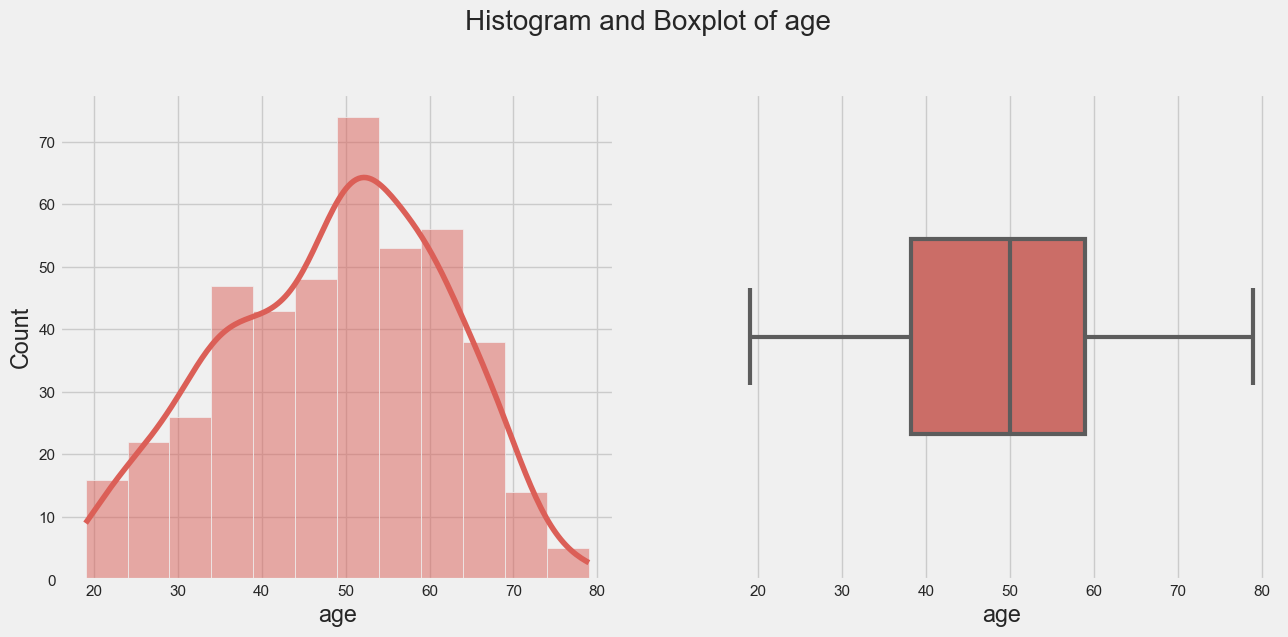

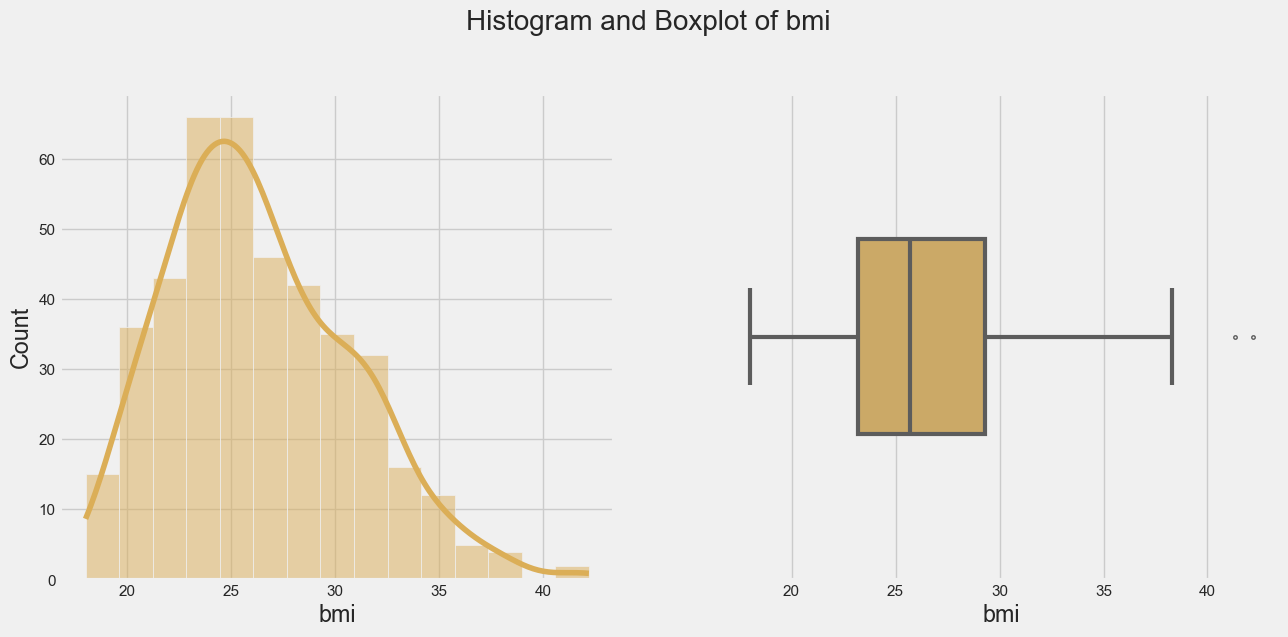

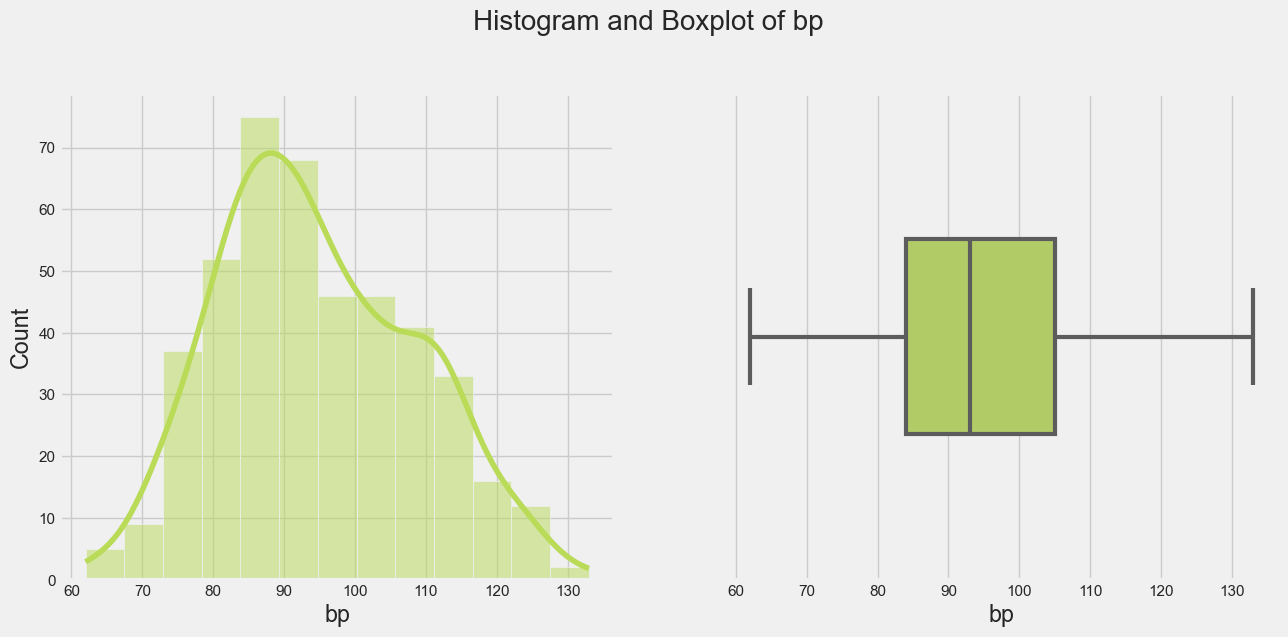

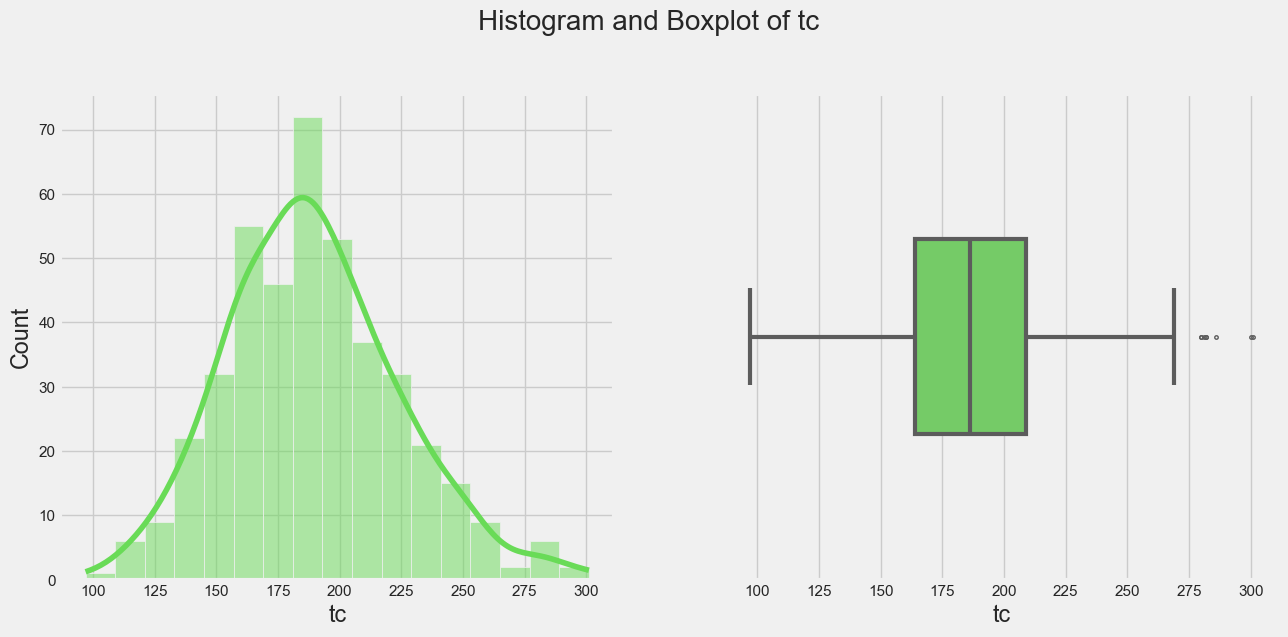

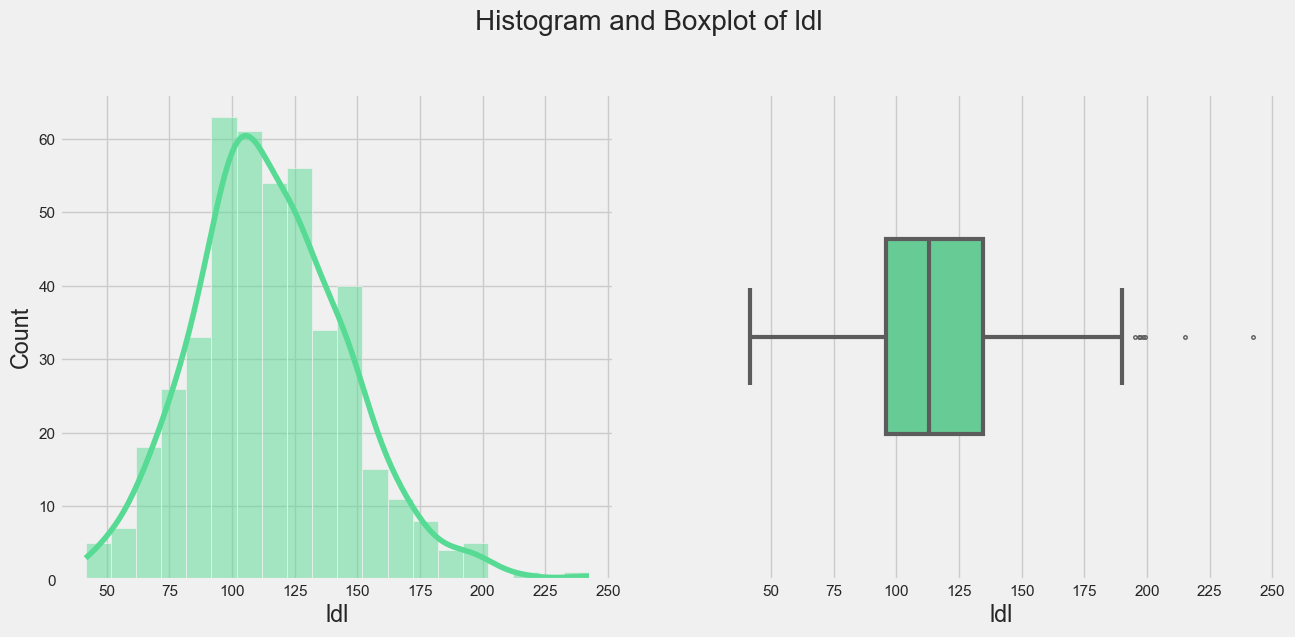

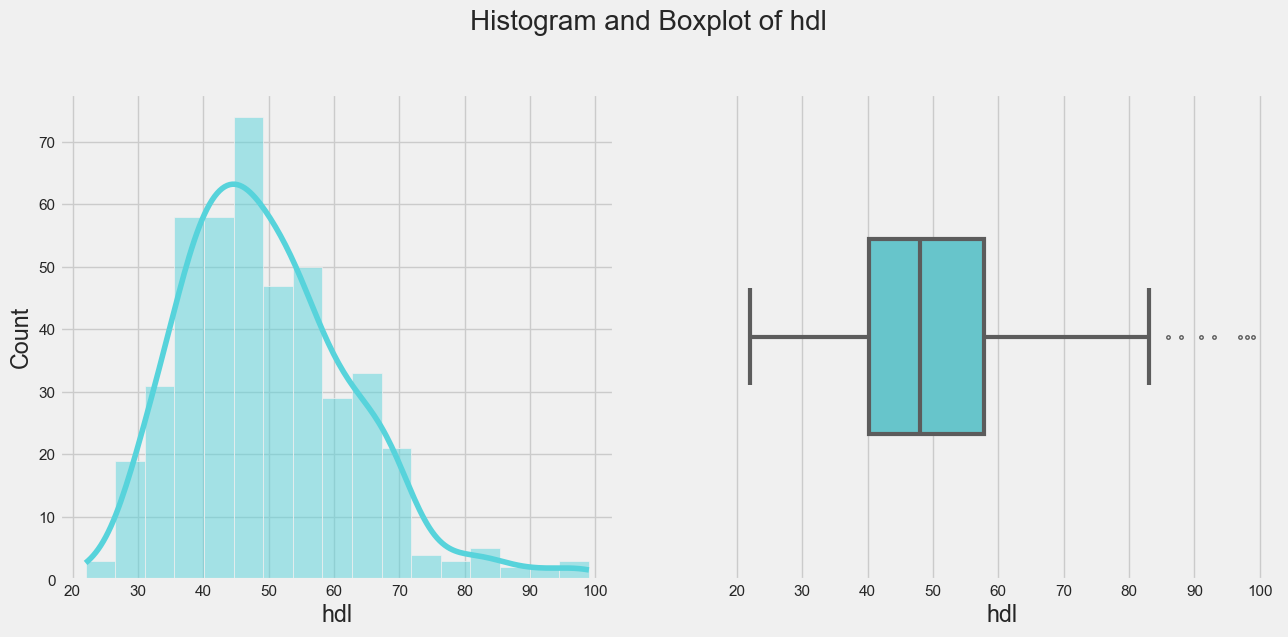

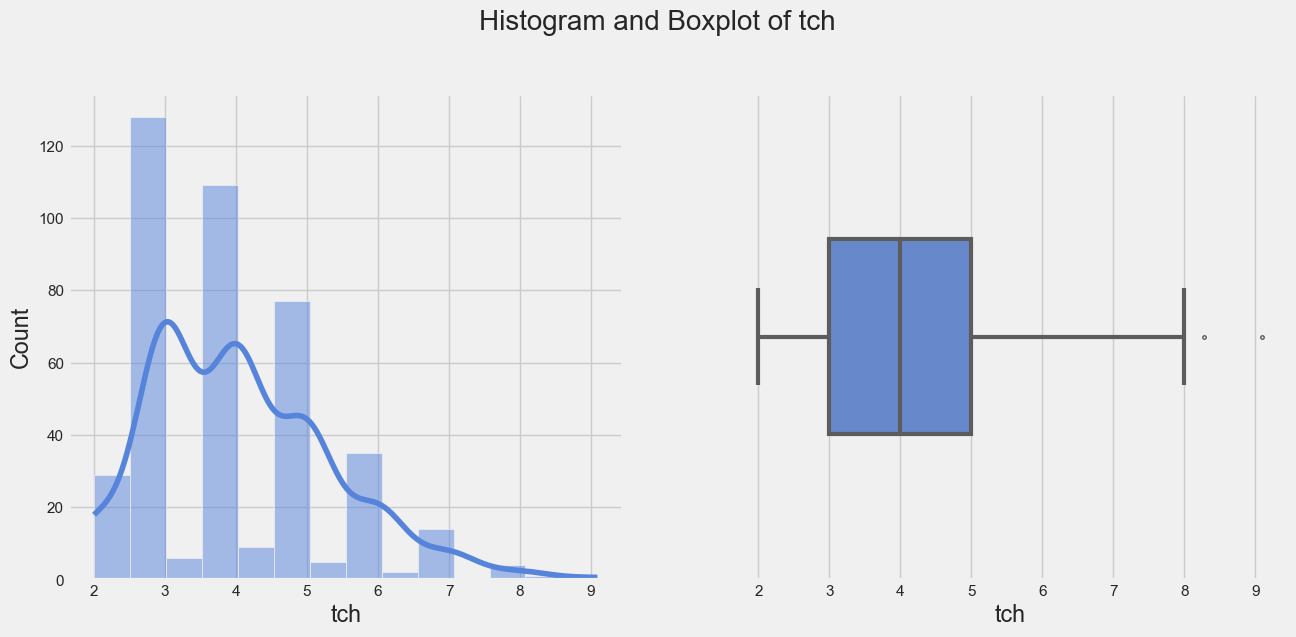

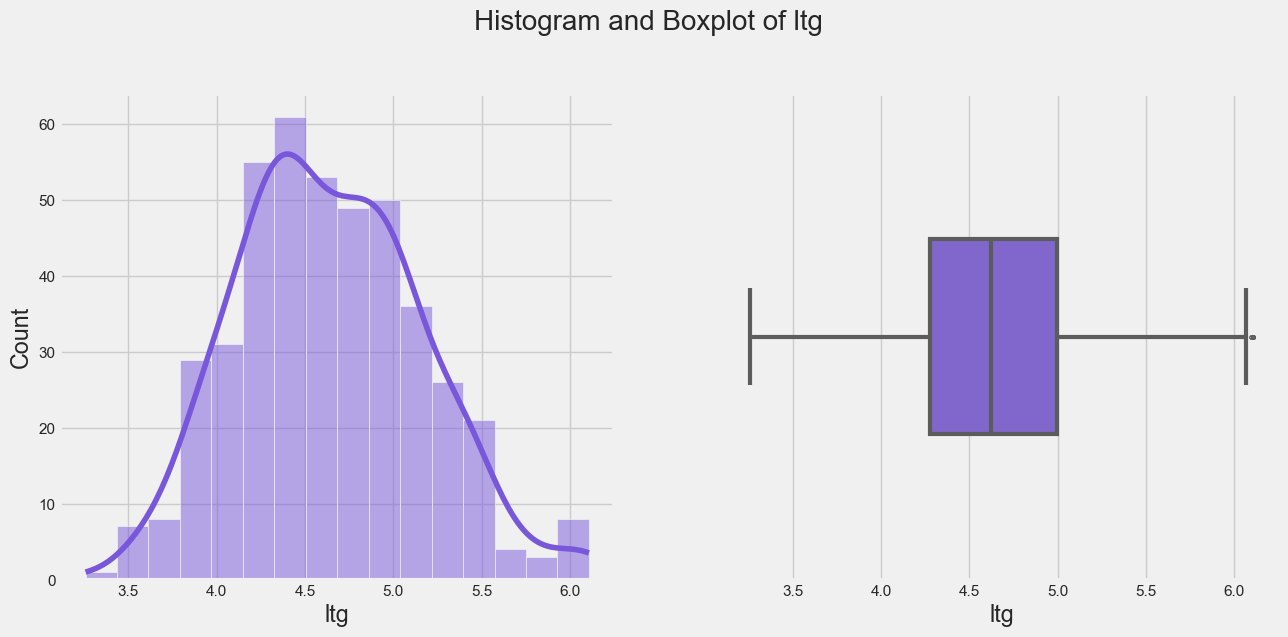

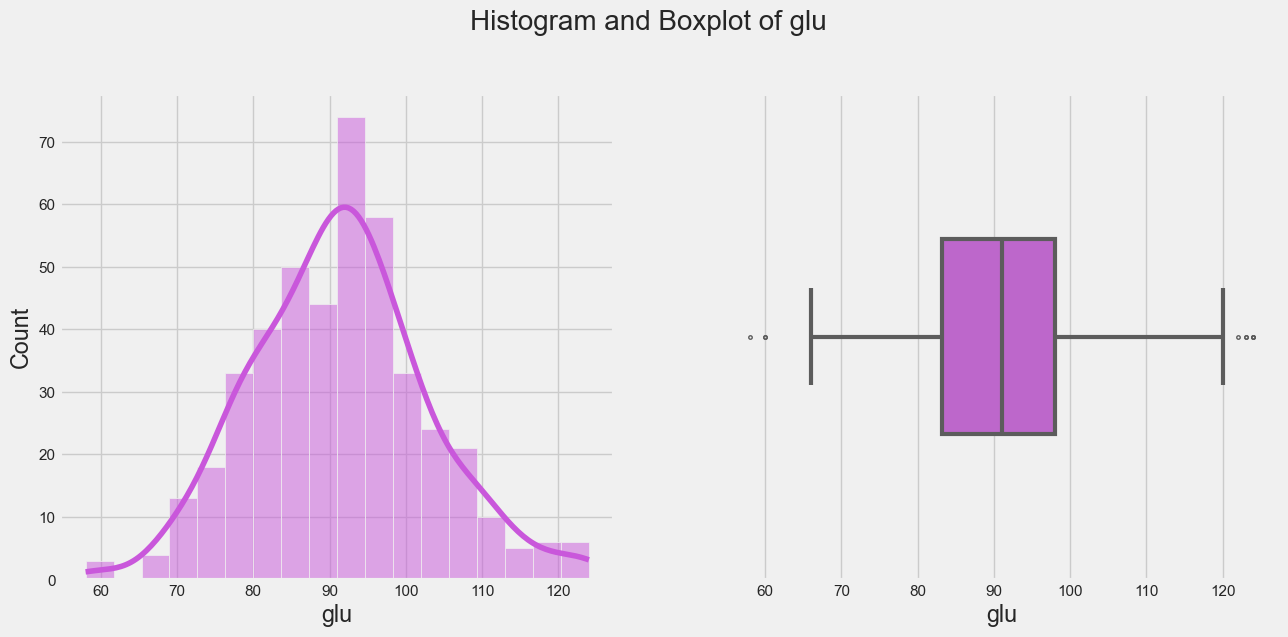

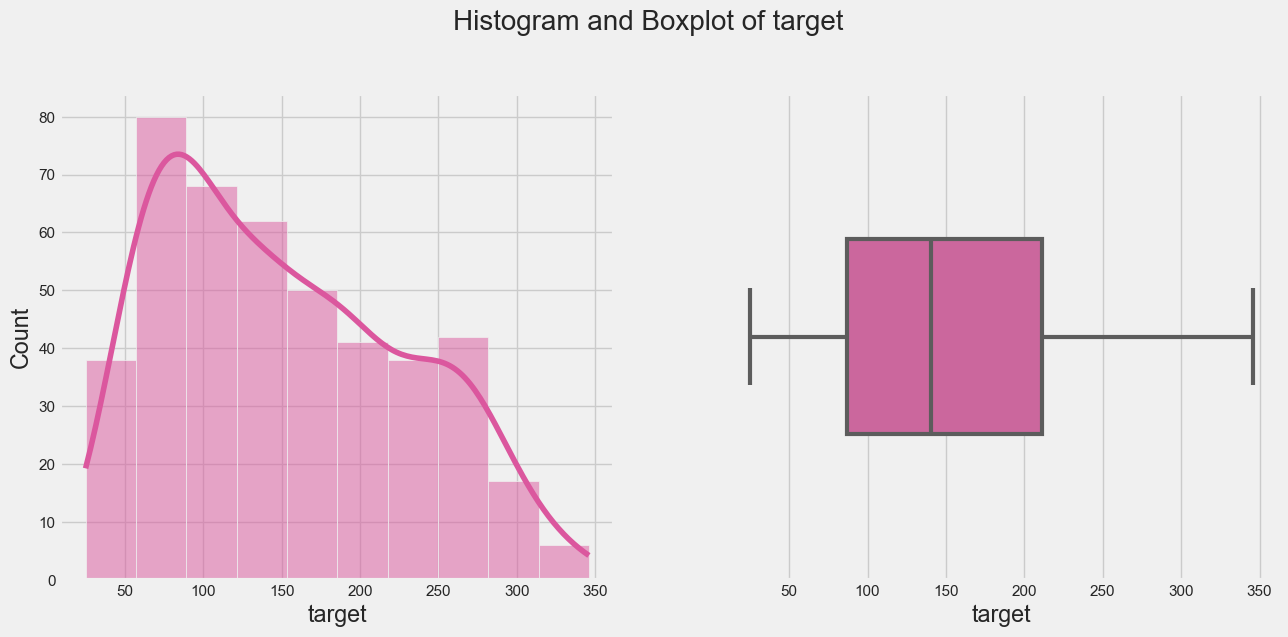

In [44]:
# Assigning column names of all columns in diabetes dataframe except 'sex'
columns_toplt = [i for i in diabetes.columns if i != 'sex']

# Call the function
plot_hist_and_box(diabetes, columns_toplt)

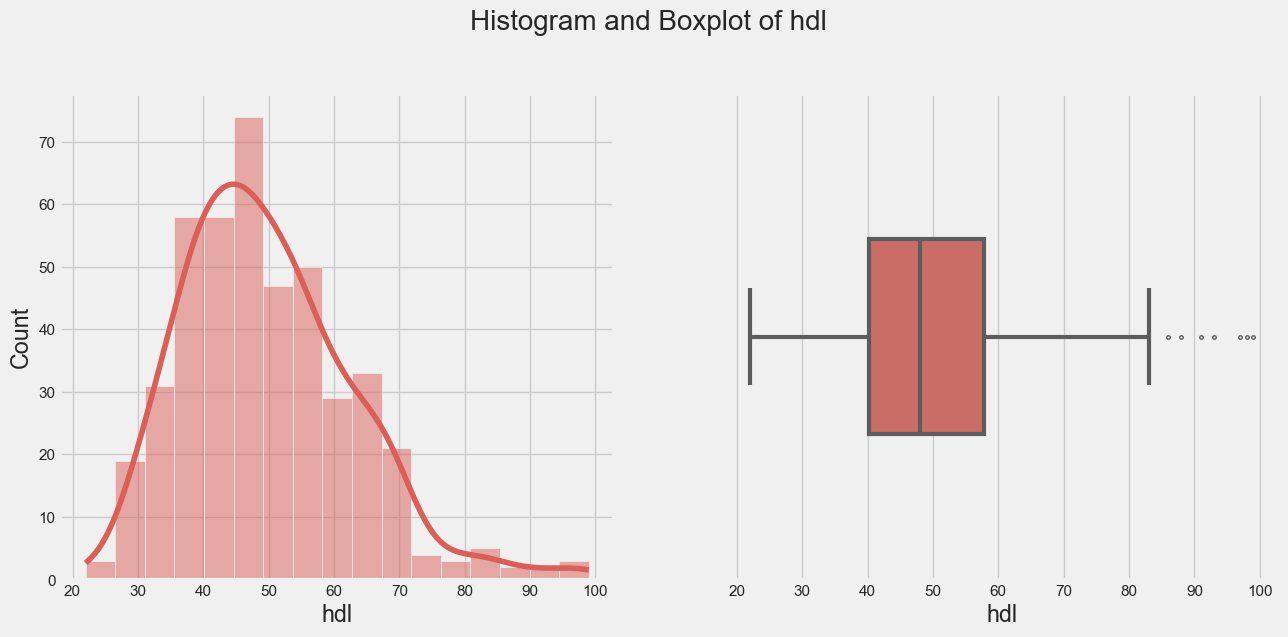

In [45]:
# looking closely into hdl column
# Assigning column name 'hdl'
columns_toplt = ['hdl']

# Call the function
plot_hist_and_box(diabetes, columns_toplt)

## Normality Test on 'hdl'

In [47]:
# Normality test on 'hdl'
stat, p = shapiro(X_train['hdl'])
print('Statistics = %.3f, p = %.3f' % (stat, p))

# Interpret
alpha = 0.05
if p > alpha:
    print("Sample is normally distributes (Fail to reject null hypothesis)")
else:
    print("Sample is not normally distributes(reject null hypothesis)")

Statistics = 0.962, p = 0.000
Sample is not normally distributes(reject null hypothesis)


## Normality Test on log of 'hdl'

In [49]:
# Normality test on 'hdl'
stat, p = shapiro(np.log(X_train['hdl']))
print('Statistics = %.3f, p = %.3f' % (stat, p))

# Interpret
alpha = 0.05
if p > alpha:
    print("Sample is normally distributes (Fail to reject null hypothesis)")
else:
    print("Sample is not normally distributes(reject null hypothesis)")

Statistics = 0.996, p = 0.700
Sample is normally distributes (Fail to reject null hypothesis)


## Linear Regression with missing observations filled with median and log of 'hdl'

In [51]:
# Replacing 'hdl' column in X_train and X_test with log of 'hdl'
X_train['hdl'] = np.log(X_train['hdl'])
X_test['hdl'] = np.log(X_test['hdl'])

# Getting Non-NAN index values for X_test
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initializing simple imputer with 'median' strategy
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')

# Fit simple imputer with training data (with log 'hdl')
imp_median.fit(X_train)

# Transforming X_train to median filled dataset and converting it to a pandas DataFrame
X_train_median_log_fill = pd.DataFrame(imp_median.transform(X_train))

# Assigning column names to the above dataframe
X_train_median_log_fill.columns= ['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']

# Fit an instance of Linear Regression
reg = LinearRegression().fit(X_train_median_log_fill, y_train)

# Generate prediction for X_test dataset
pred = reg.predict(X_test.loc[nonnan_test_indices])

# Calculate Root Mean Squared error 
root_mean_squared_error(y_test.loc[nonnan_test_indices], pred)

55.685863090763554

### Root mean squared error has improved. Looking into column 'ldl' for more improvements

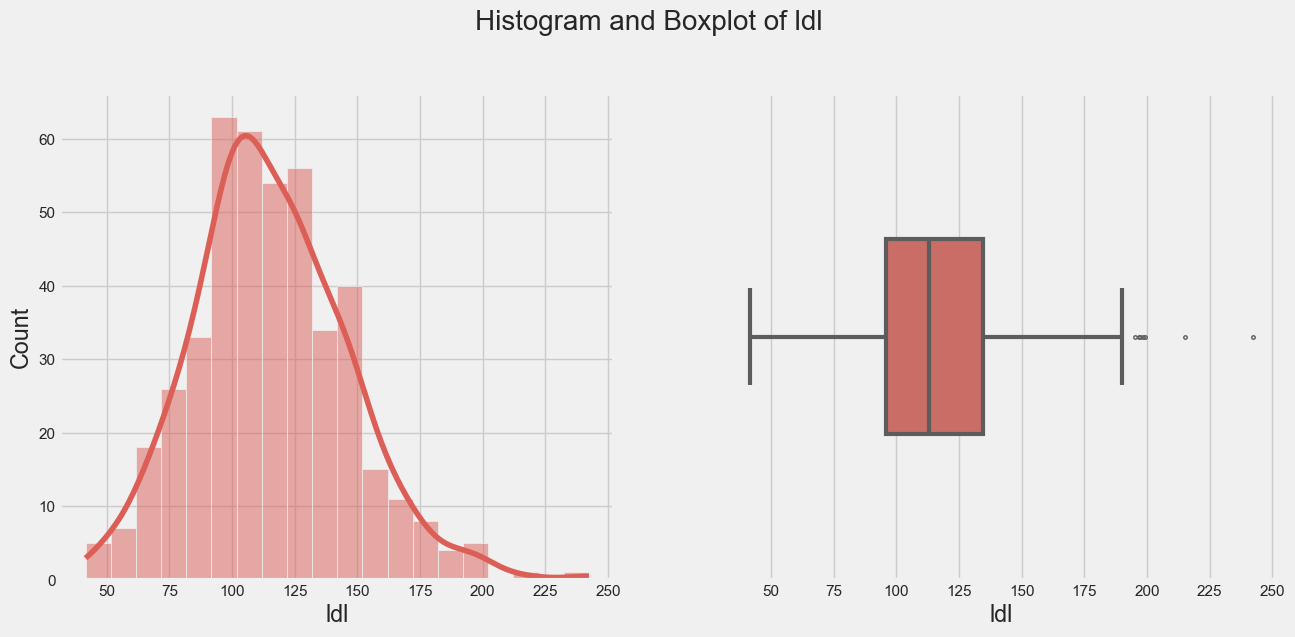

In [53]:
# looking closely into ldl column
# Assigning column name 'ldl'
columns_toplt = ['ldl']

# Call the function
plot_hist_and_box(diabetes, columns_toplt)

## Linear Regression with missing observations filled with median, log of 'hdl' and removal of oultiers in 'ldl'

In [55]:
# Removing outlier index from 'idl'
X_train_nonoutlier_idx = X_train.index[X_train.ldl < X_train.ldl.quantile(0.999)]
X_train = X_train.loc[X_train_nonoutlier_idx]
y_train = y_train.loc[X_train_nonoutlier_idx]

# Getting Non-NAN index values for X_test
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Initializing simple imputer with 'median' strategy
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')

# Fit simple imputer with training data (with log 'hdl')
imp_median.fit(X_train)

# Transforming X_train to median filled dataset and converting it to a pandas DataFrame
X_train_median_log_fill = pd.DataFrame(imp_median.transform(X_train))

# Assigning column names to the above dataframe
X_train_median_log_fill.columns= ['age', 'sex', 'bmi', 'bp', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']

# Fit an instance of Linear Regression
reg = LinearRegression().fit(X_train_median_log_fill, y_train)

# Generate prediction for X_test dataset
pred = reg.predict(X_test.loc[nonnan_test_indices])

# Calculate Root Mean Squared error 
root_mean_squared_error(y_test.loc[nonnan_test_indices], pred)

55.53368308287885

## Correlation Matrix

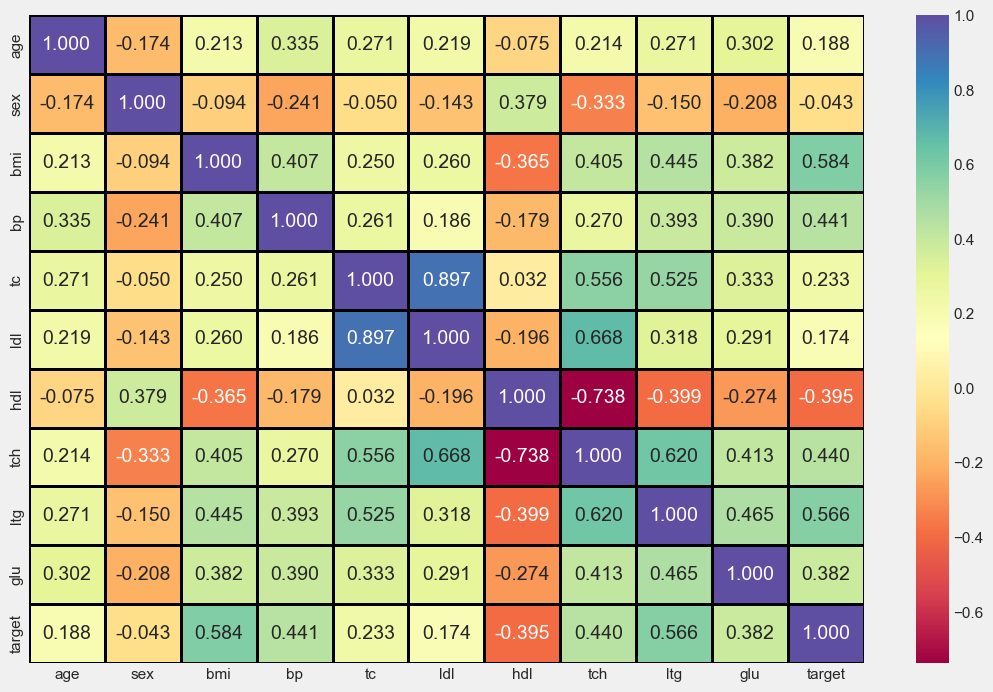

In [57]:
plt.figure(figsize = (12, 8))
sns.heatmap(diabetes.corr(), annot = True, cmap = 'Spectral', linewidth = 2, linecolor = '#000000', fmt = '.3f')
plt.show()

It can be observed that the correlation of 'tc' and 'idl' to 'target' is very low. Hence the we might be able to improve the regression model by dropping the column 'tc'

## Linear Regression with meadian filled, log of 'hdl', removed outliers in 'idl' and dropping 'tc'

In [60]:
# Removing outlier index from 'idl'
X_train_nonoutlier_idx = X_train.index[X_train.ldl < X_train.ldl.quantile(0.999)]
X_train = X_train.loc[X_train_nonoutlier_idx]
y_train = y_train.loc[X_train_nonoutlier_idx]

# Getting Non-NAN index values for X_test
nonnan_test_indices = X_test.index[~X_test.isna().max(axis=1)]

# Getting column names except 'tc'
col_no_tc = [i for i in X_train.columns if i != 'tc']

# Initializing simple imputer with 'median' strategy
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')

# Fit simple imputer with training data (with log 'hdl')
imp_median.fit(X_train.loc[:, col_no_tc])

# Transforming X_train to median filled dataset and converting it to a pandas DataFrame
X_train_median_log_fill = pd.DataFrame(imp_median.transform(X_train.loc[:, col_no_tc]))

# Assigning column names to the above dataframe
X_train_median_log_fill.columns= ['age', 'sex', 'bmi', 'bp', 'ldl', 'hdl', 'tch', 'ltg', 'glu']

# Fit an instance of Linear Regression
reg = LinearRegression().fit(X_train_median_log_fill, y_train)

# Generate prediction for X_test dataset
pred = reg.predict(X_test.loc[nonnan_test_indices, col_no_tc])

# Calculate Root Mean Squared error 
root_mean_squared_error(y_test.loc[nonnan_test_indices], pred)

55.619929987460424

Removal of 'tc' column has lead to worse performance

## Pair Plots

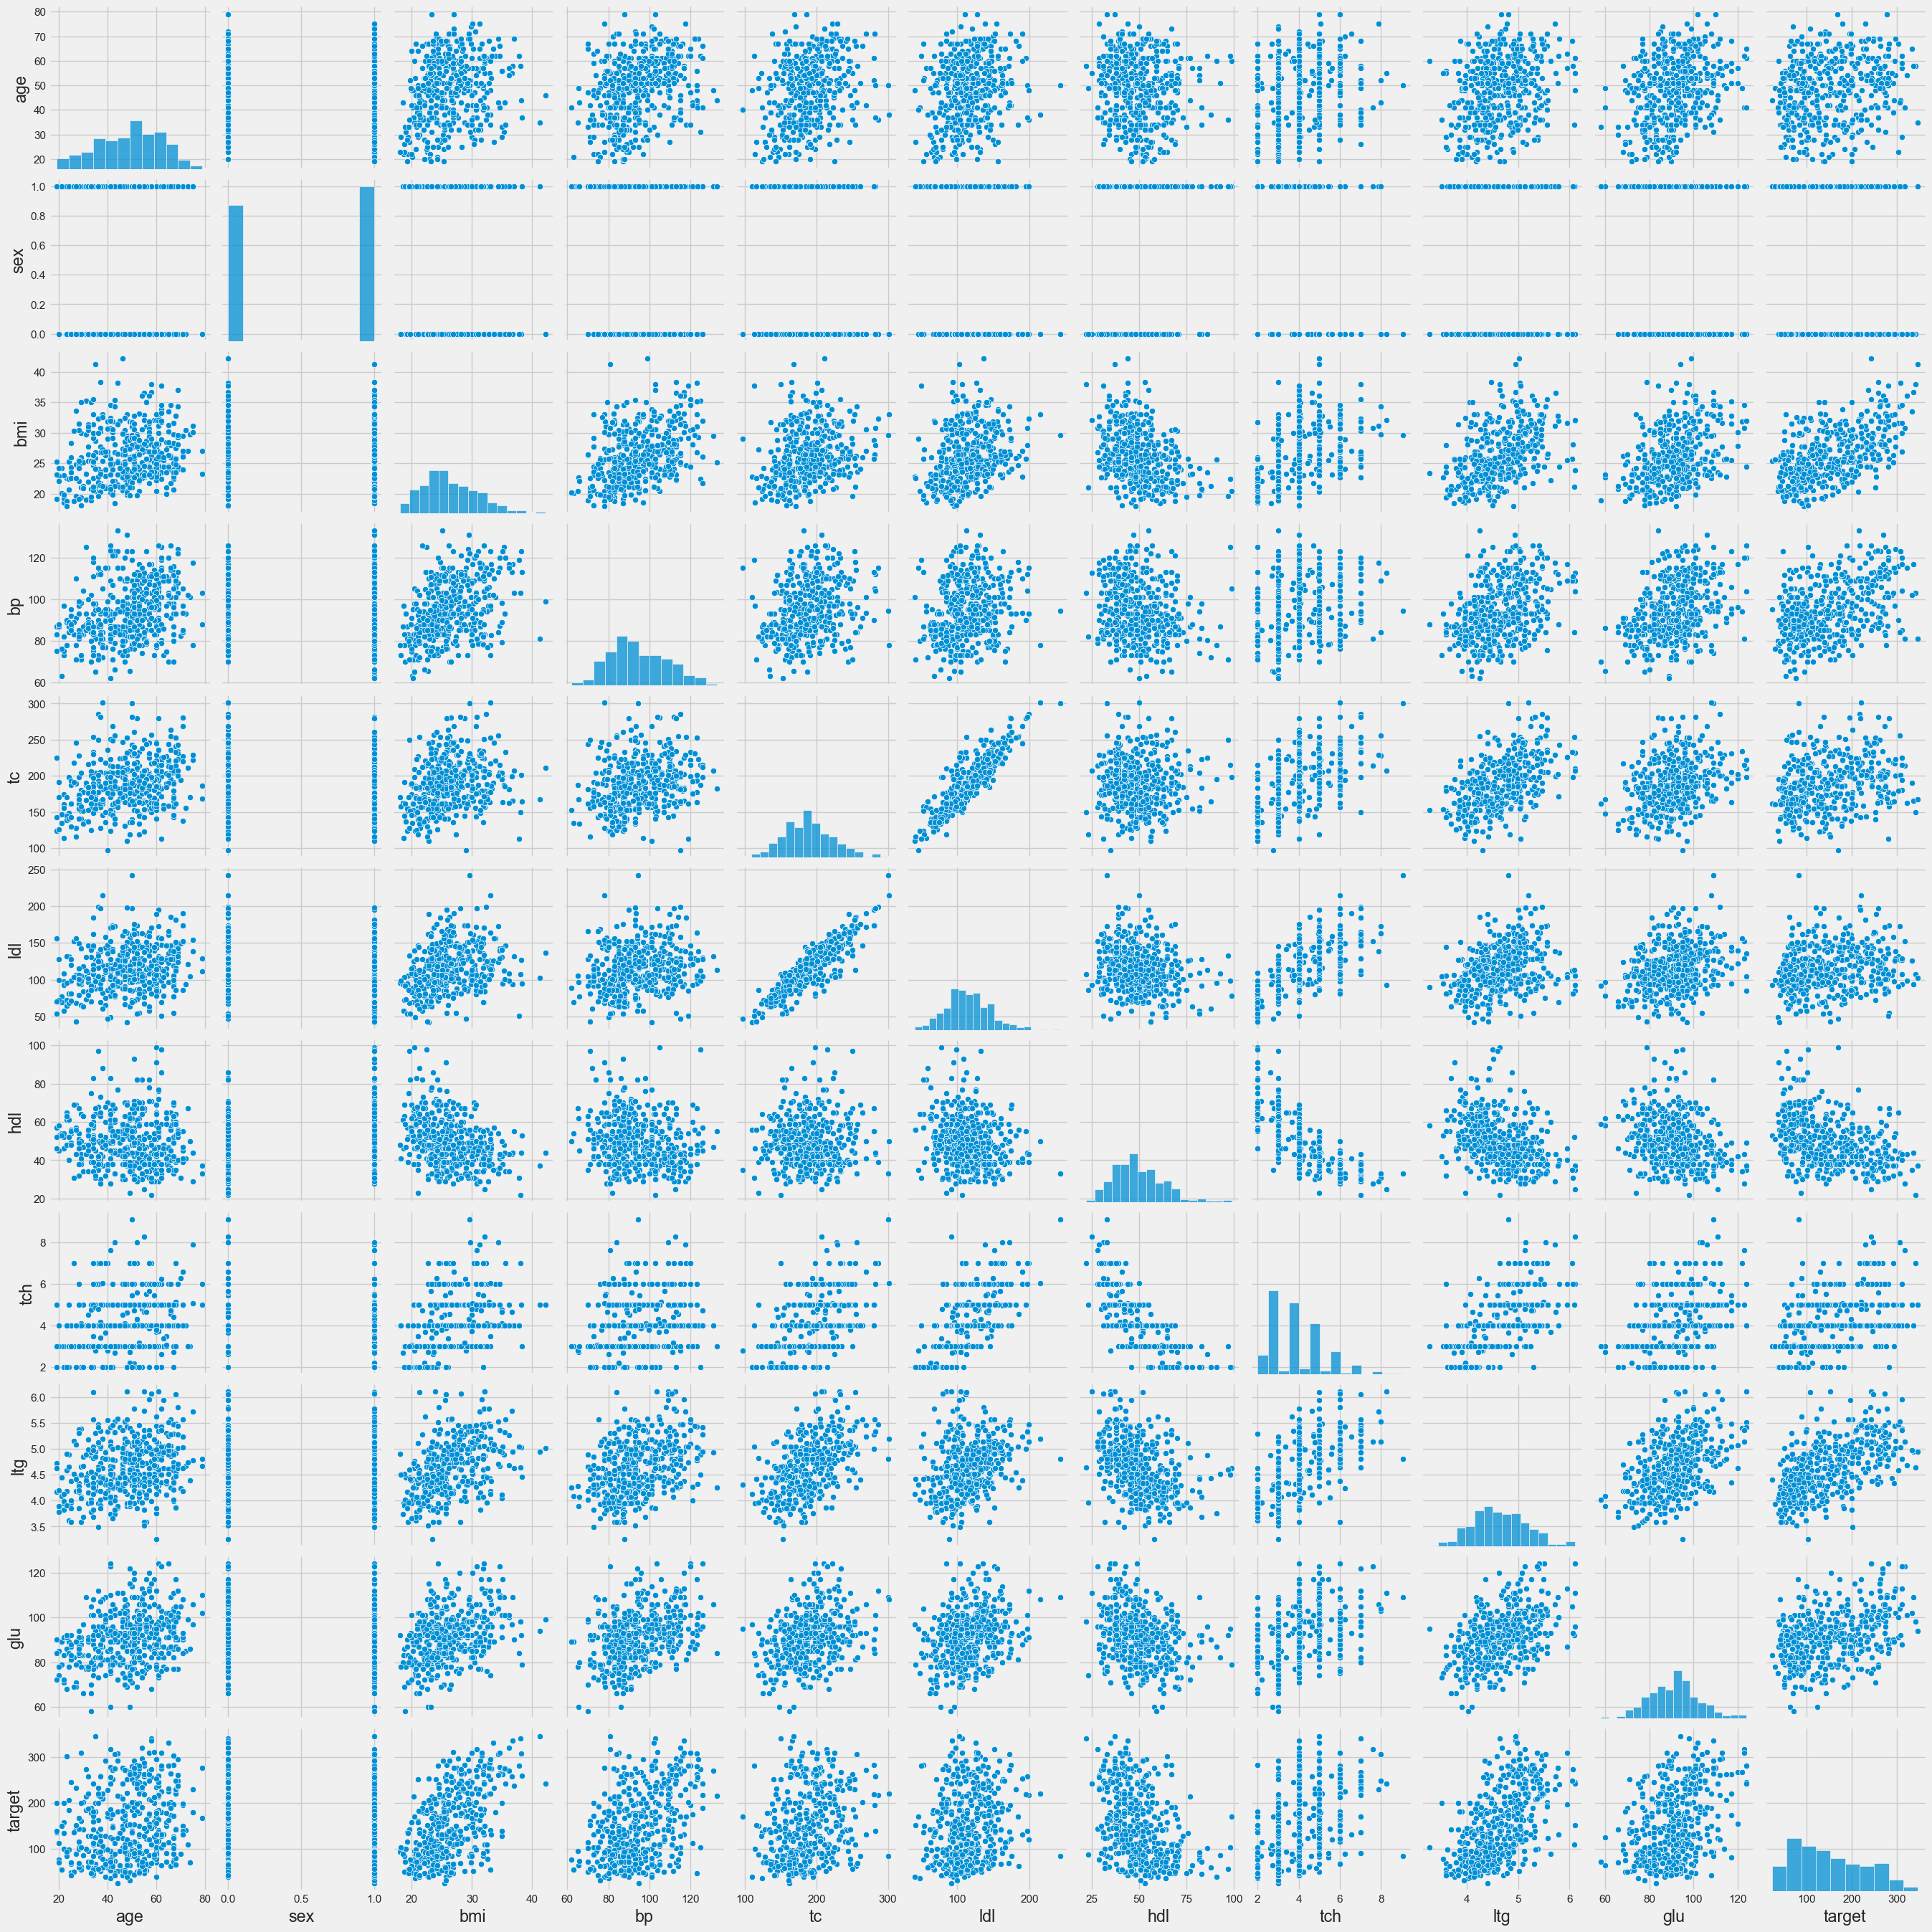

In [63]:
sns.pairplot(diabetes)
plt.show()

## A Simple function to perform EDA - fasteda

The fast_eda from fasteda package does all the above EDA analysis in single step

DataFrame Head:


age  sex   bmi     bp     tc    ldl   hdl  tch     ltg   glu  target
0  59.0  0.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0   151.0
1  48.0  1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0    75.0
2  72.0  0.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0   141.0

DataFrame Tail:


age  sex   bmi     bp     tc    ldl   hdl   tch     ltg   glu  target
439  60.0  0.0  24.9  99.67  162.0  106.6  43.0  3.77  4.1271  95.0   132.0
440  36.0  1.0  30.0  95.00  201.0  125.2  42.0  4.79  5.1299  85.0   220.0
441  36.0  1.0  19.6  71.00  250.0  133.2  97.0  3.00  4.5951  92.0    57.0

----------------------------------------------------------------------------------------------------
Missing values:


----------------------------------------------------------------------------------------------------
MSNO Matrix:



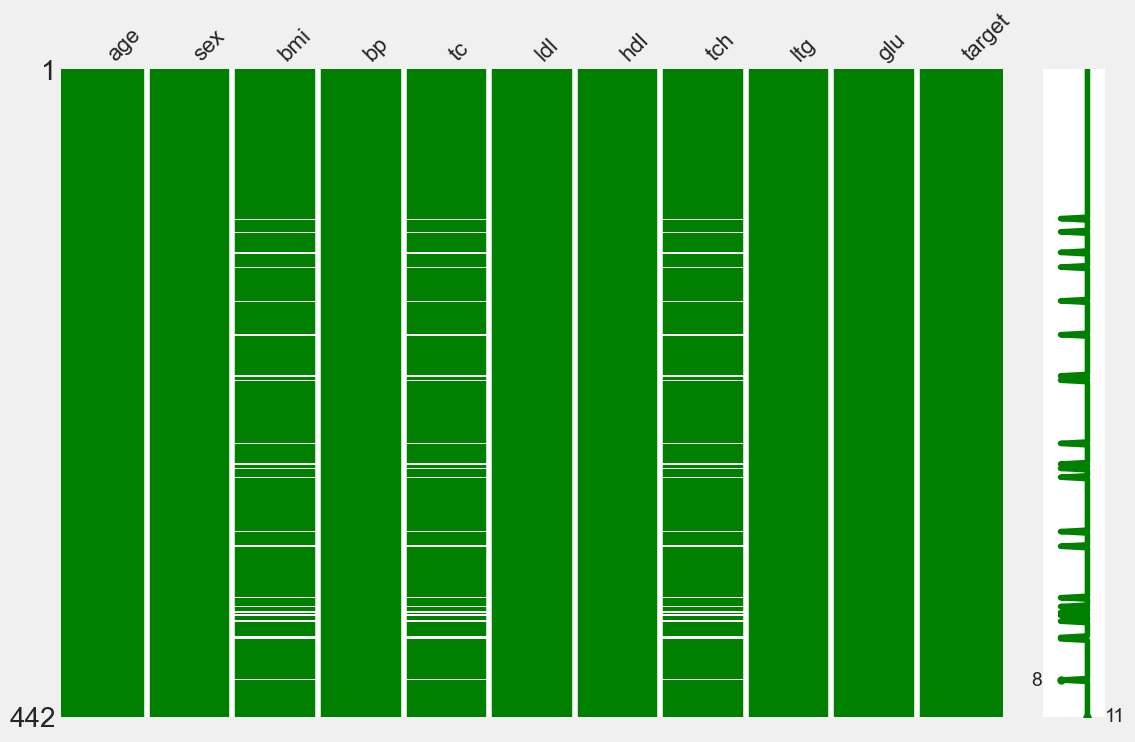

----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(442, 11)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     420 non-null    float64
 3   bp      442 non-null    float64
 4   tc      420 non-null    float64
 5   ldl     442 non-null    float64
 6   hdl     442 non-null    float64
 7   tch     420 non-null    float64
 8   ltg     442 non-null    float64
 9   glu     442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



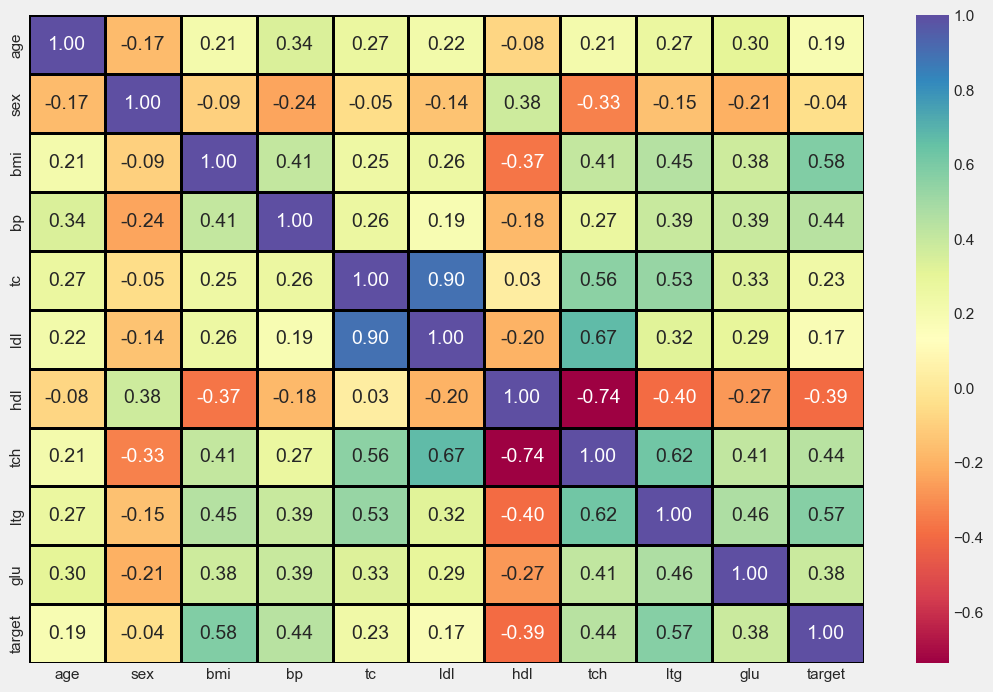

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



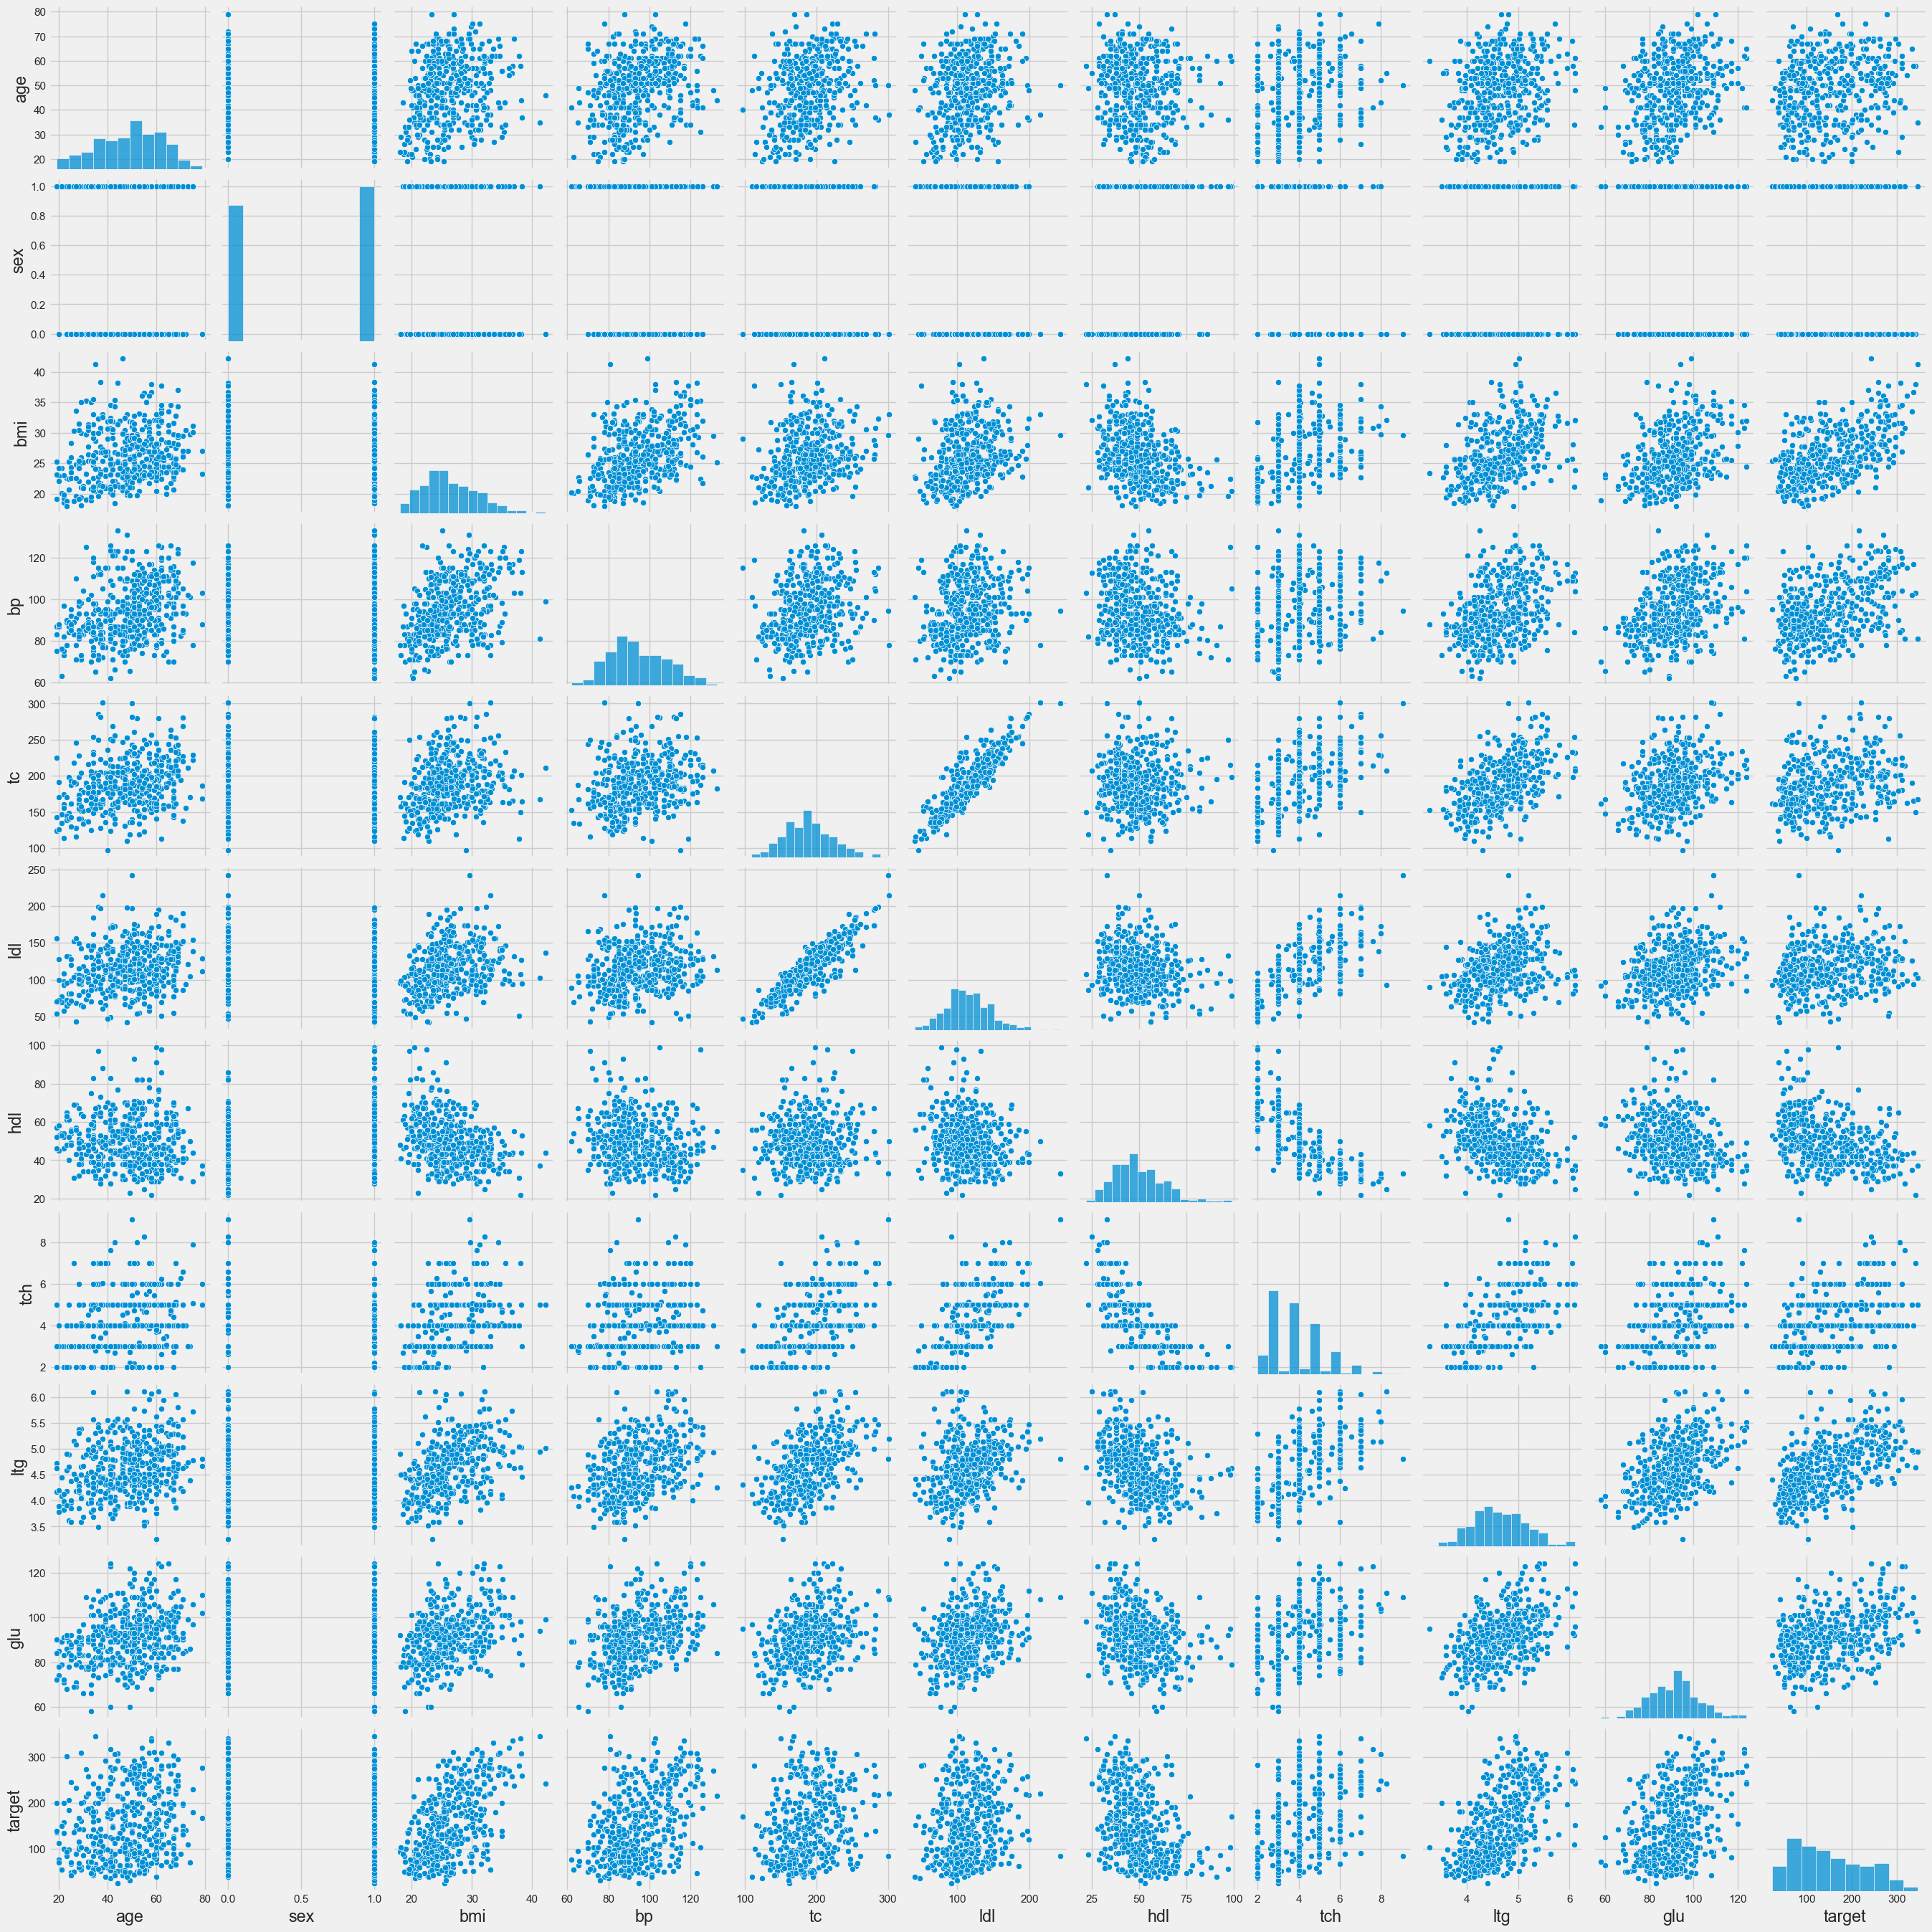

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



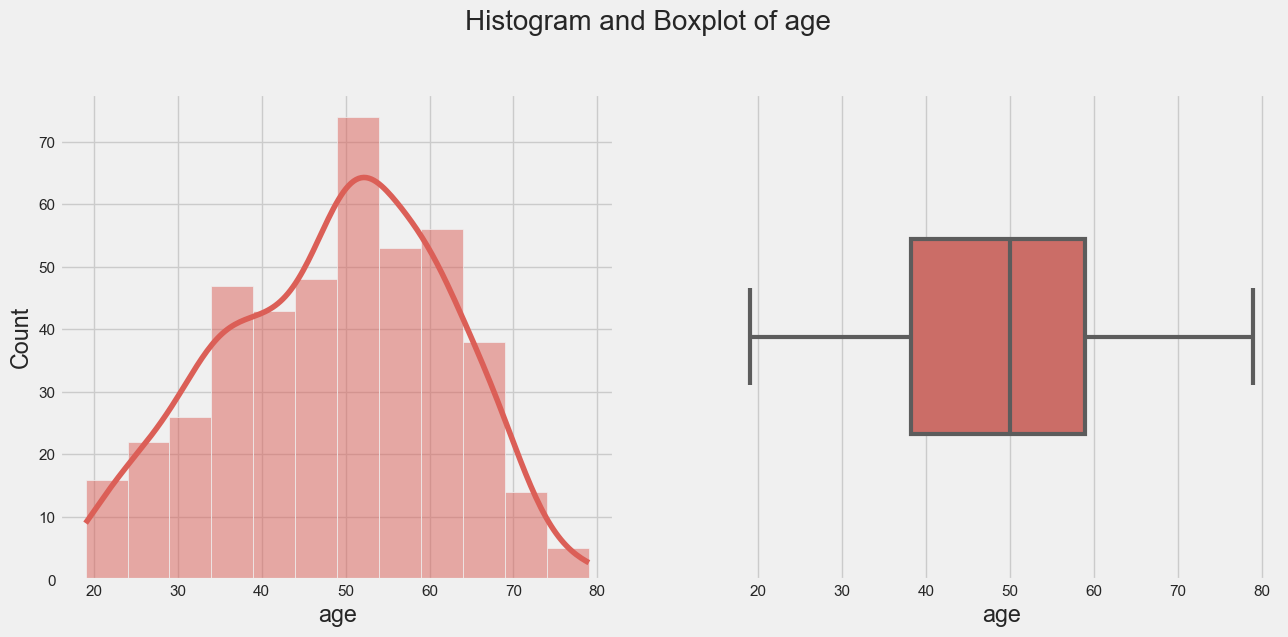

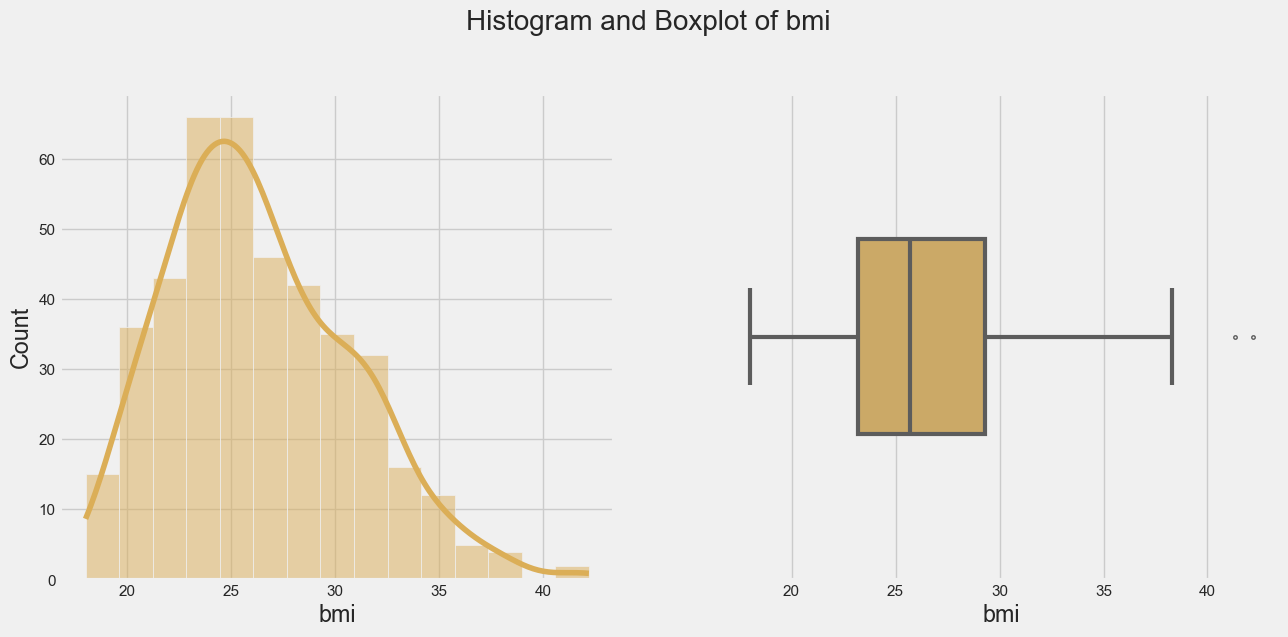

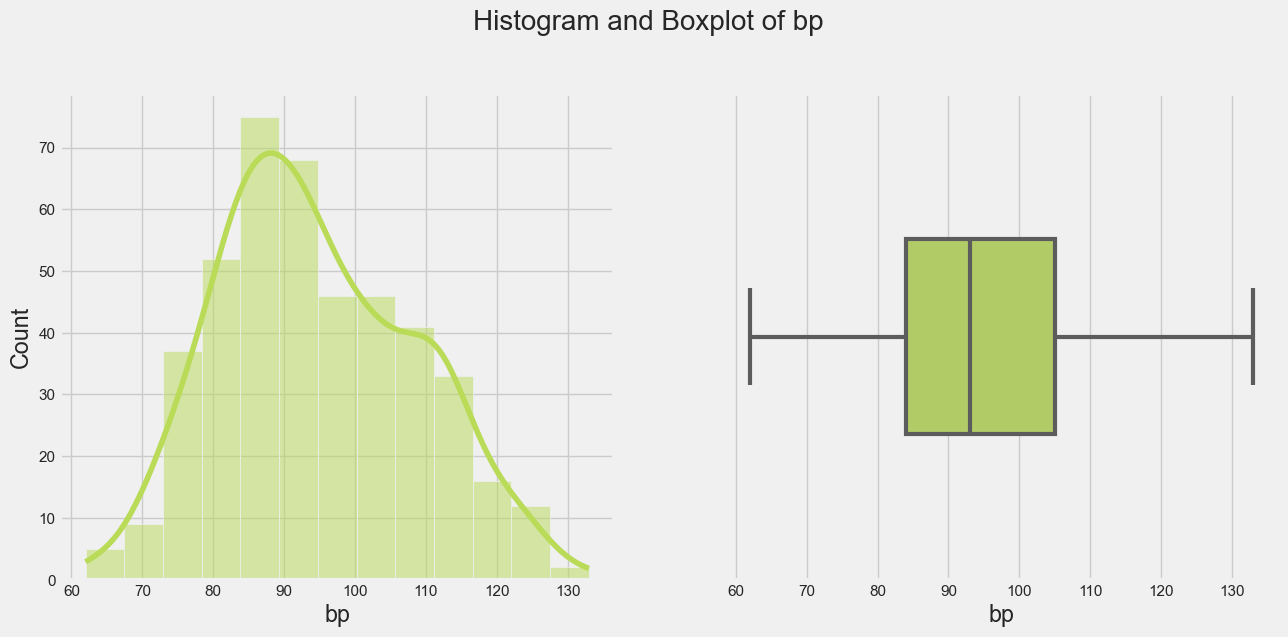

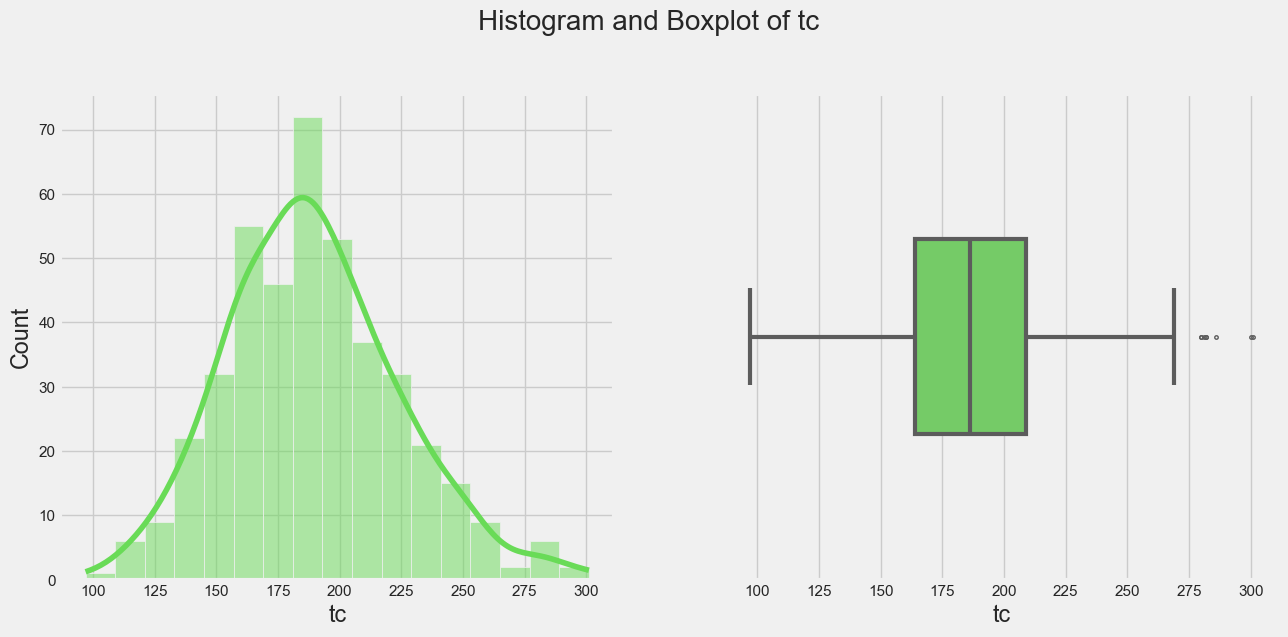

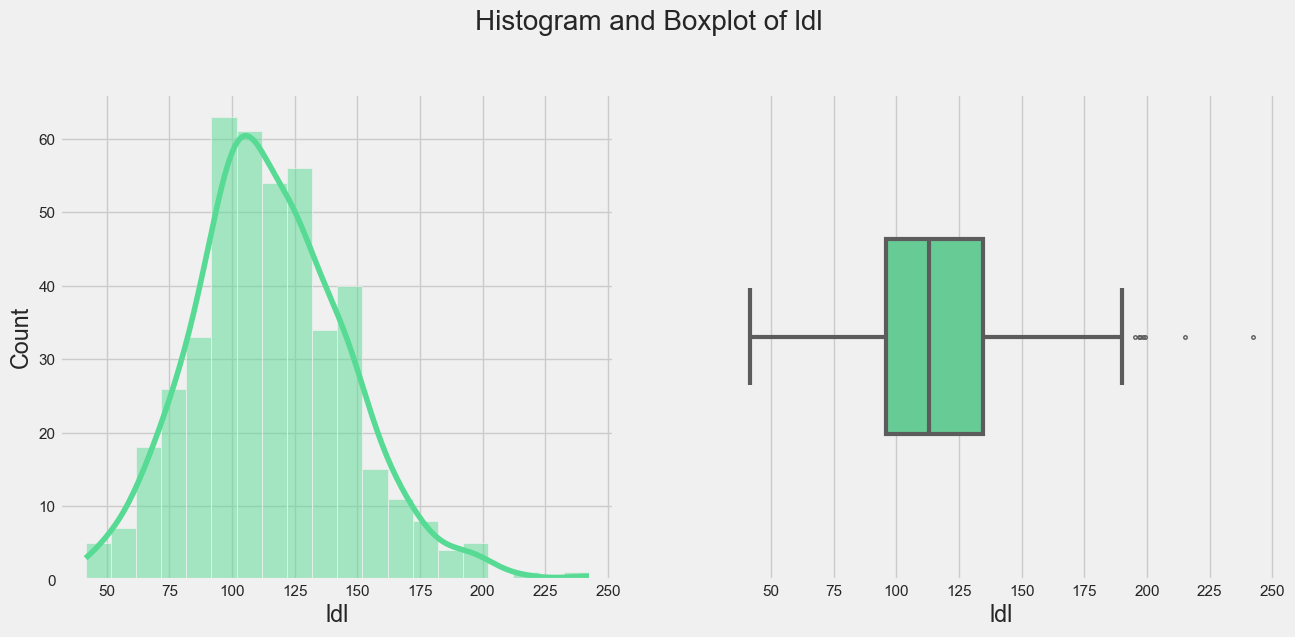

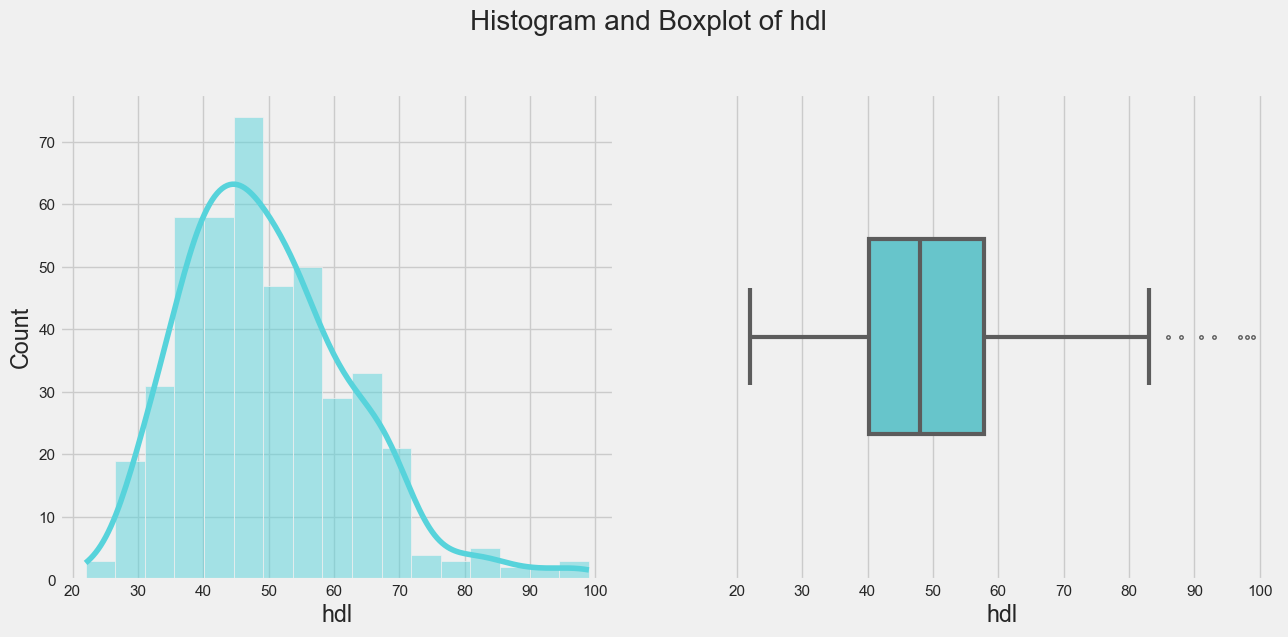

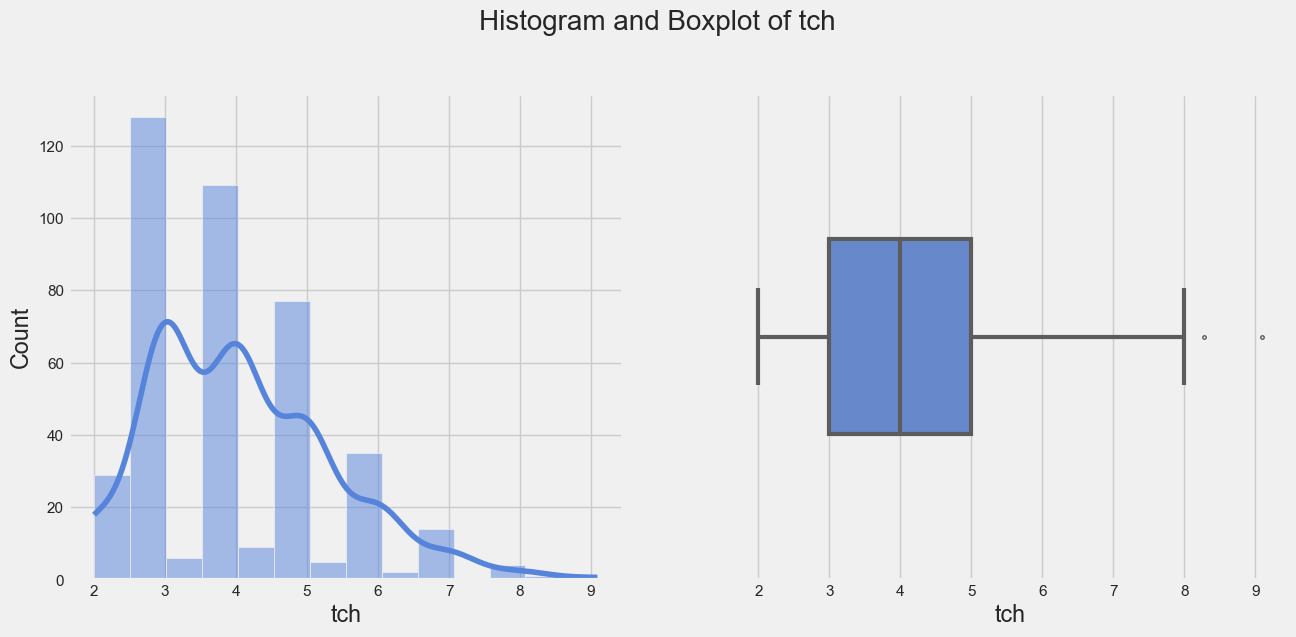

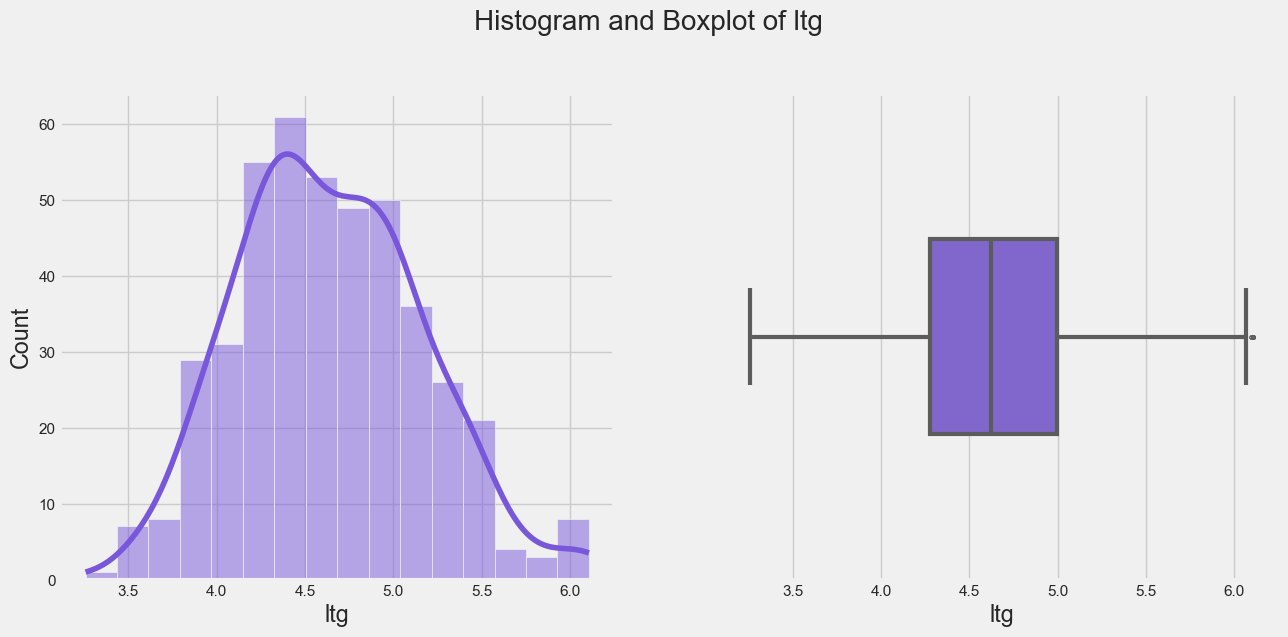

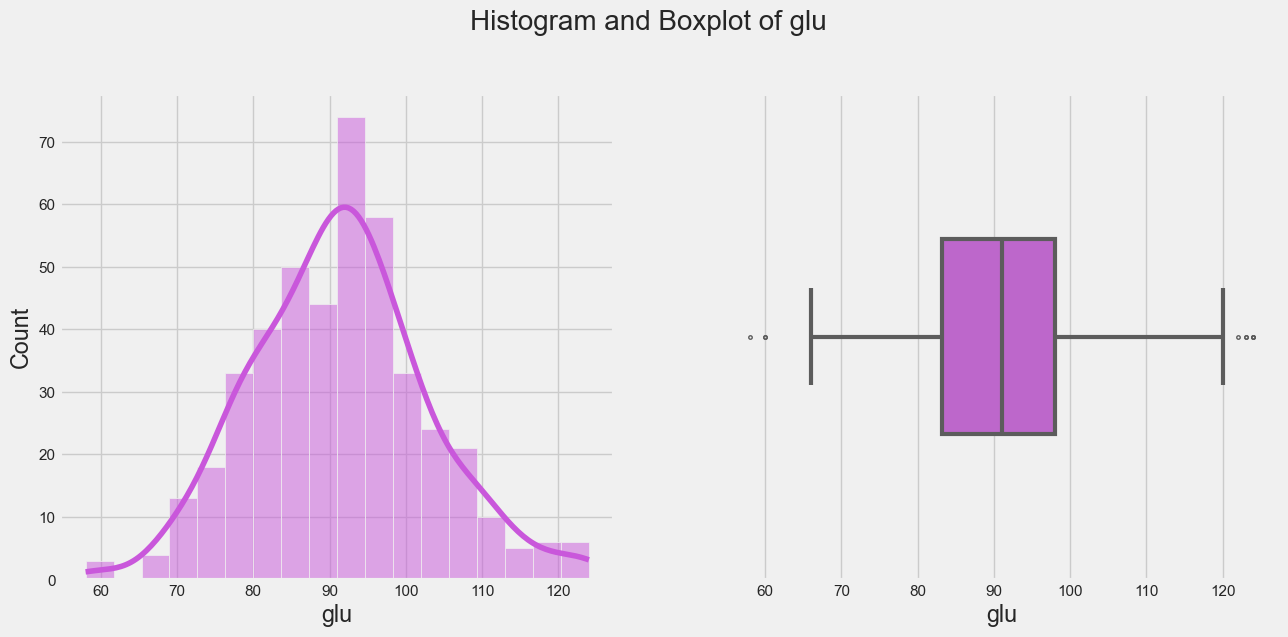

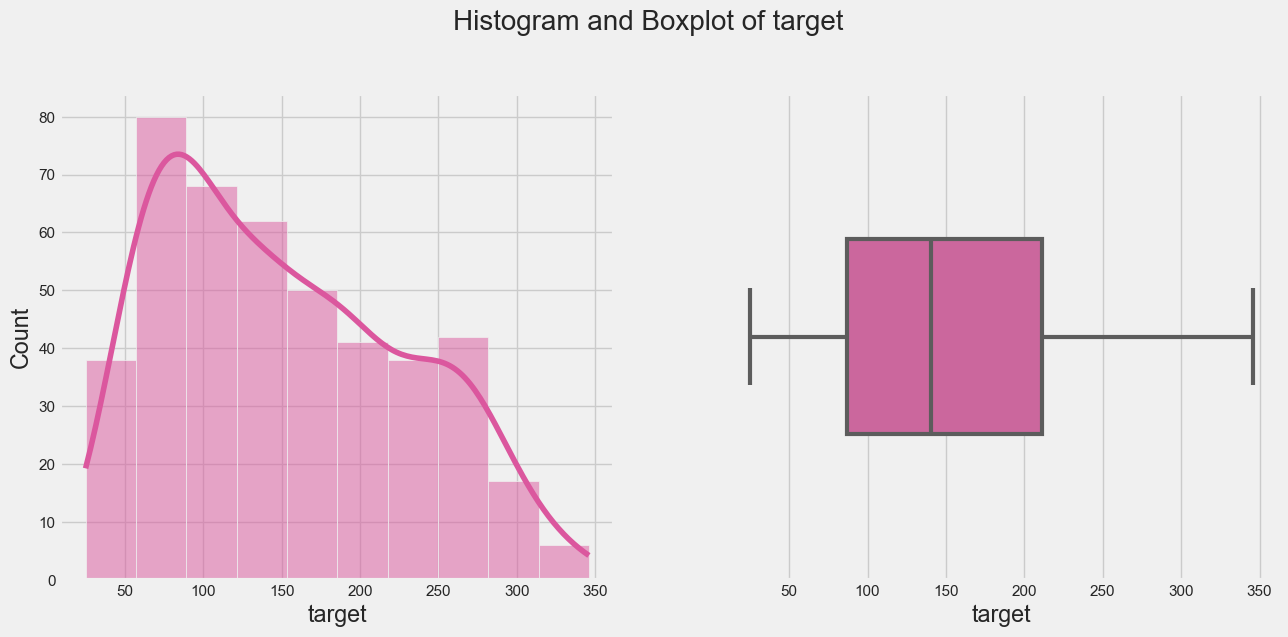

----------------------------------------------------------------------------------------------------
Countplot(s):



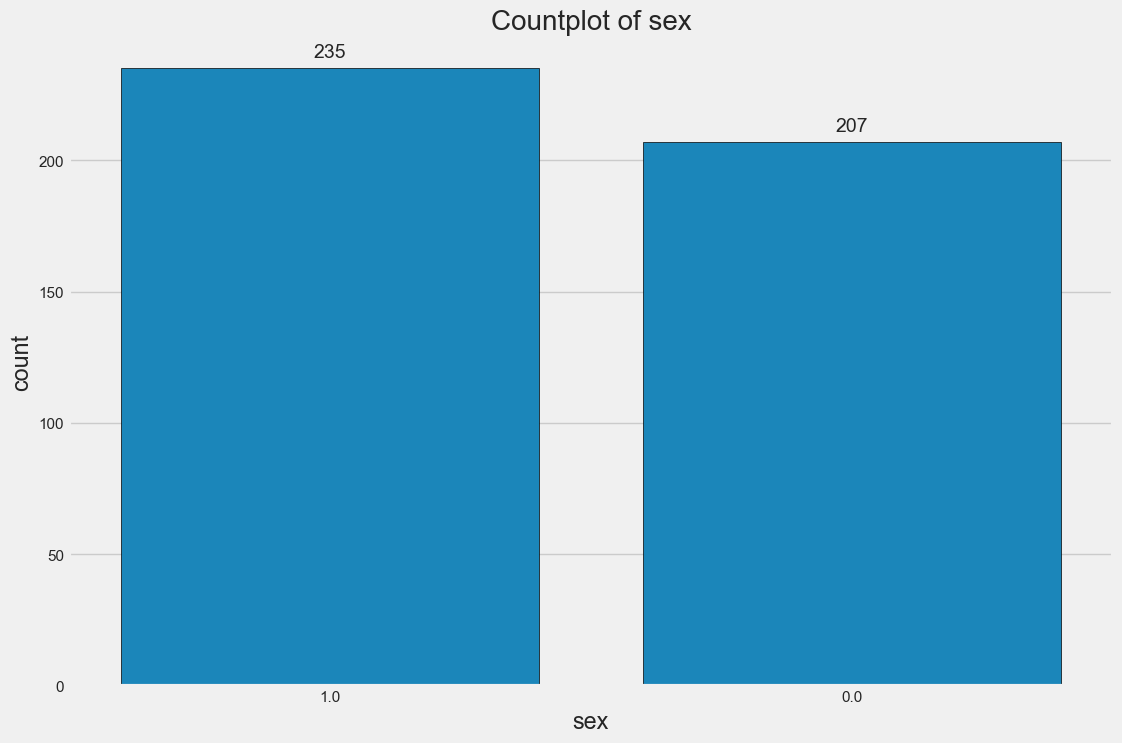

In [66]:
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

# Now run fast_eda(diabetes) function
fast_eda(diabetes)


# Classification

## Import Iris Data Set

In [69]:
# Load the data set from sklearn
iris_sklearn = load_iris()

# Extract the data and target labels as a numpy array
iris_npy = np.concatenate([iris_sklearn['data'], np.atleast_2d(iris_sklearn['target']).T], axis=1)

# Define column names
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target']

# Convert the numpy array to a pandas dataframe with column names
iris = pd.DataFrame(iris_npy, columns=col_names)

# Print a description of the dataset
print(iris_sklearn['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [70]:
iris['target'].sample(5)

111    2.0
71     1.0
16     0.0
56     1.0
122    2.0
Name: target, dtype: float64

In [71]:
class_names = dict(zip(list(map(float, range(len(iris_sklearn['target_names'])))), iris_sklearn['target_names']))
print(class_names)

{0.0: 'setosa', 1.0: 'versicolor', 2.0: 'virginica'}


## Performing EDA for classification using fasteda

DataFrame Head:


sepal_length  sepal_width  petal_length  petal_width  target
0           5.1          3.5           1.4          0.2     0.0
1           4.9          3.0           1.4          0.2     0.0
2           4.7          3.2           1.3          0.2     0.0

DataFrame Tail:


sepal_length  sepal_width  petal_length  petal_width  target
147           6.5          3.0           5.2          2.0     2.0
148           6.2          3.4           5.4          2.3     2.0
149           5.9          3.0           5.1          1.8     2.0

----------------------------------------------------------------------------------------------------
Missing values:


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(150, 5)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   target        150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB
----------------------------------------------------------------------------------------------------
Describe DataFrame:



----------------------------------------------------------------------------------------------------
DataFrame Correlation:



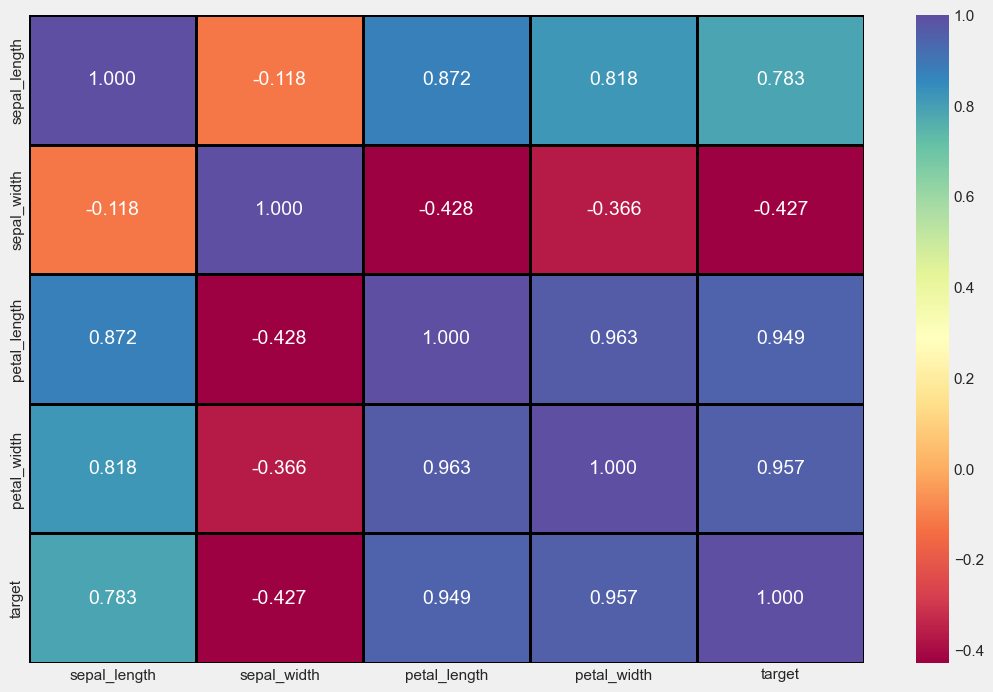

----------------------------------------------------------------------------------------------------
DataFrame Pairplot:



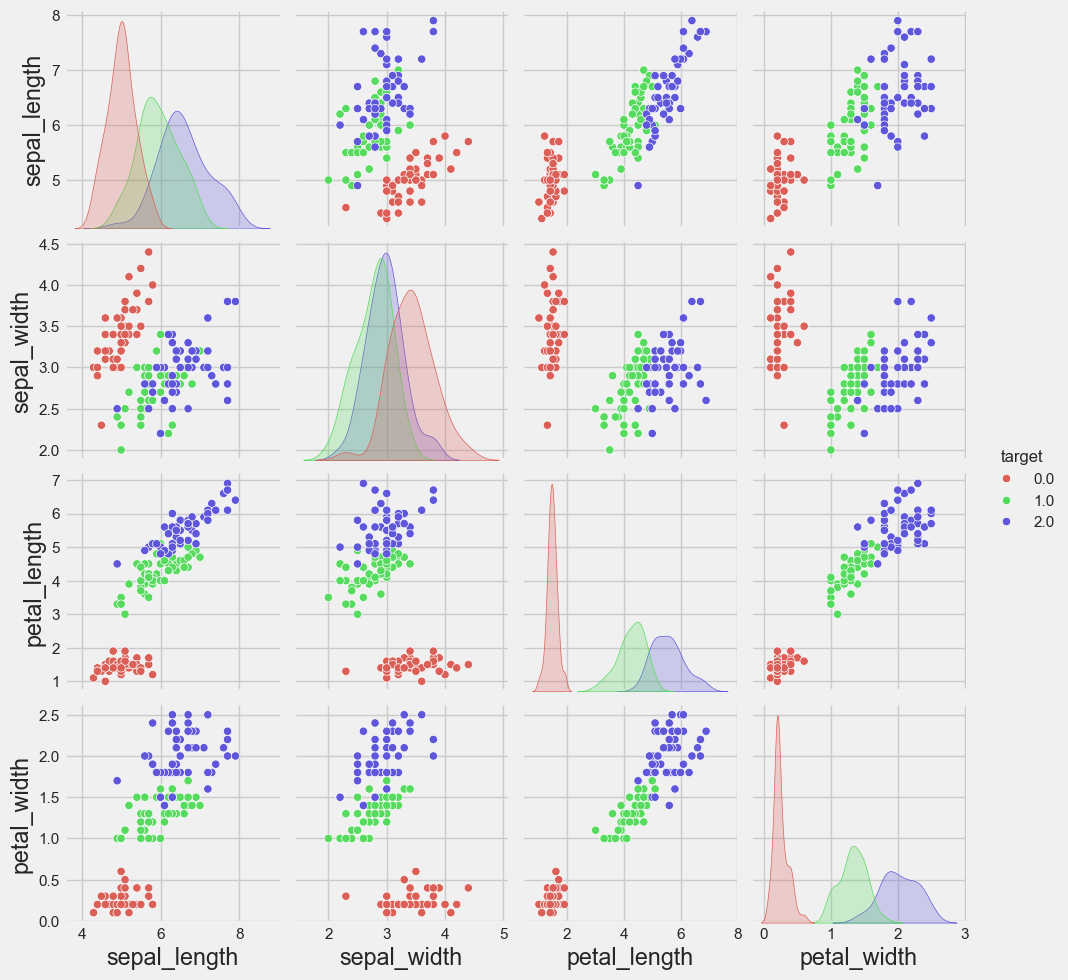

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



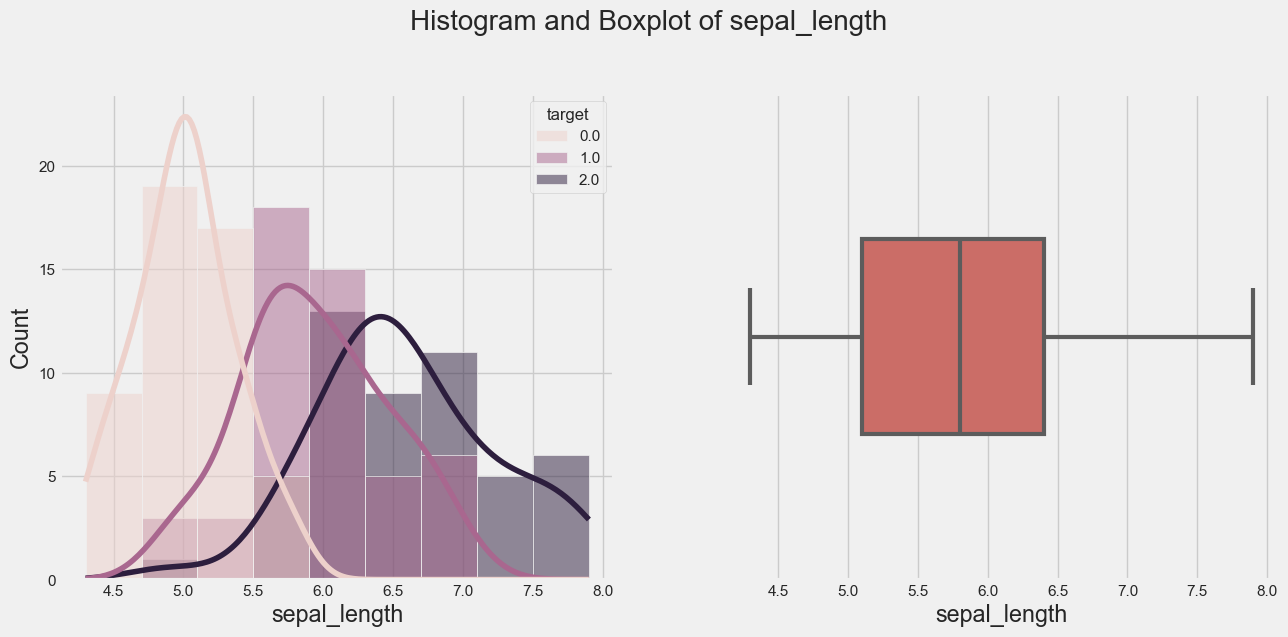

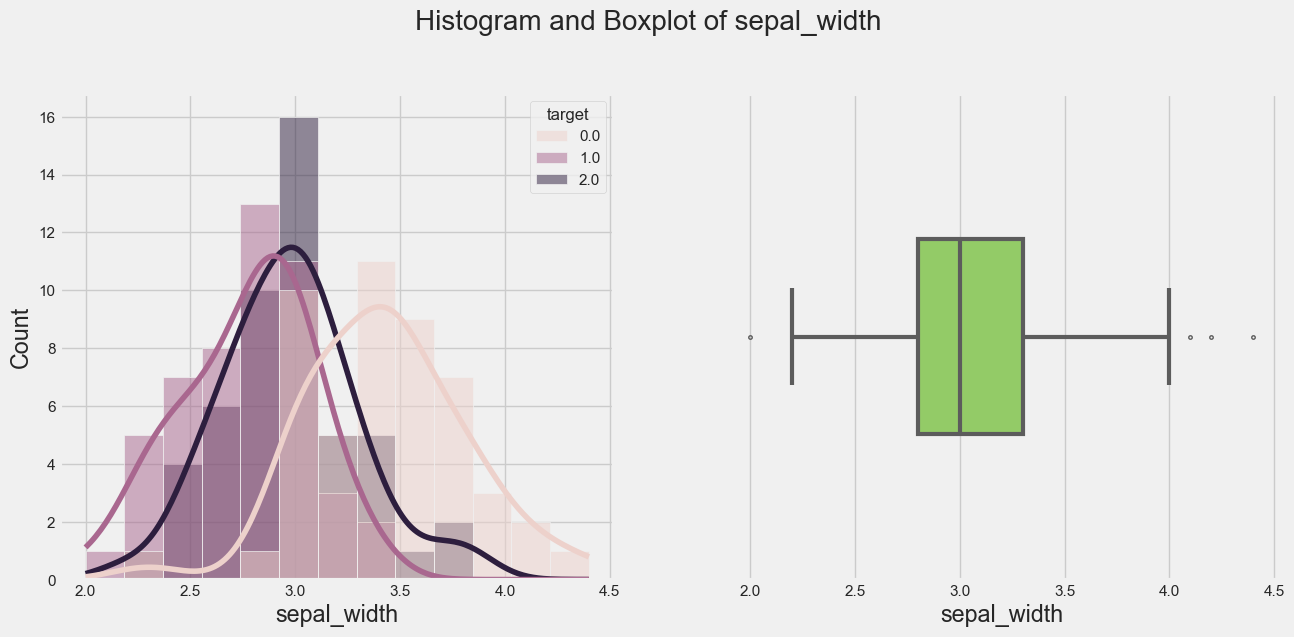

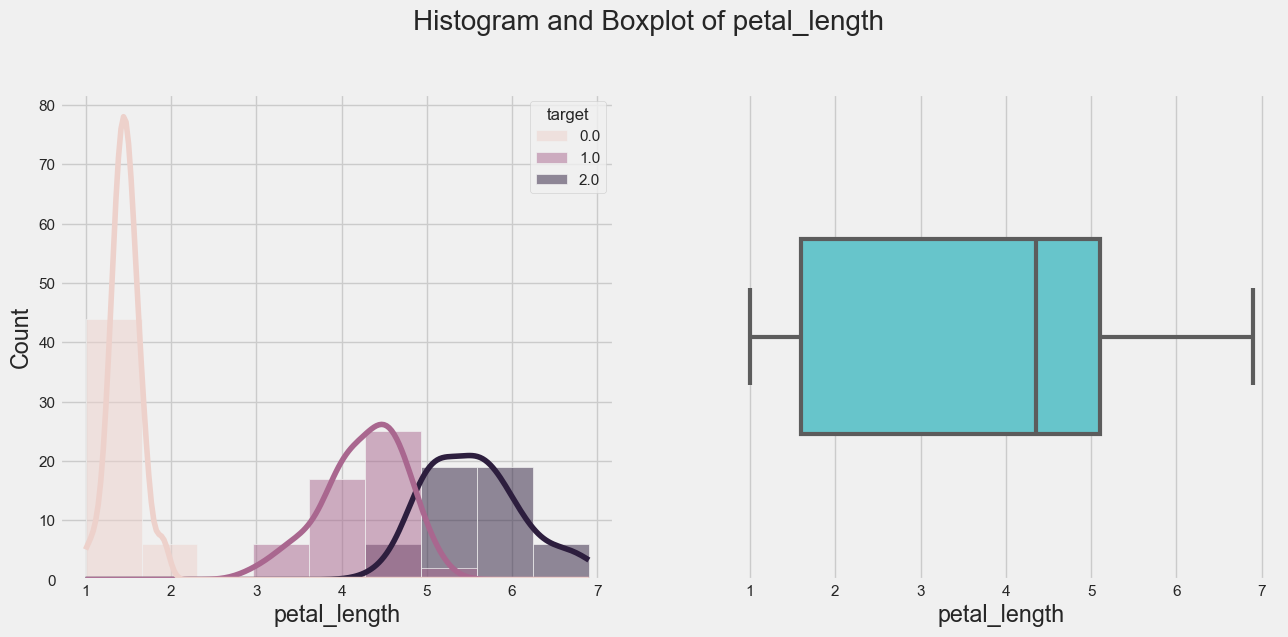

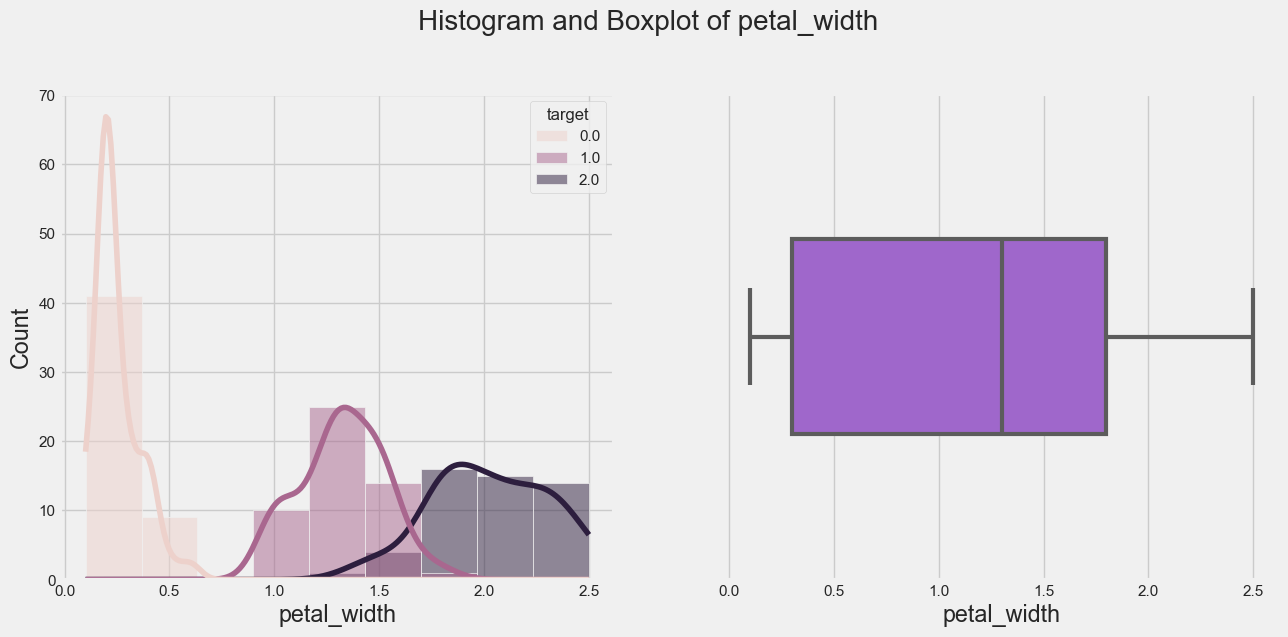

----------------------------------------------------------------------------------------------------
Countplot(s):



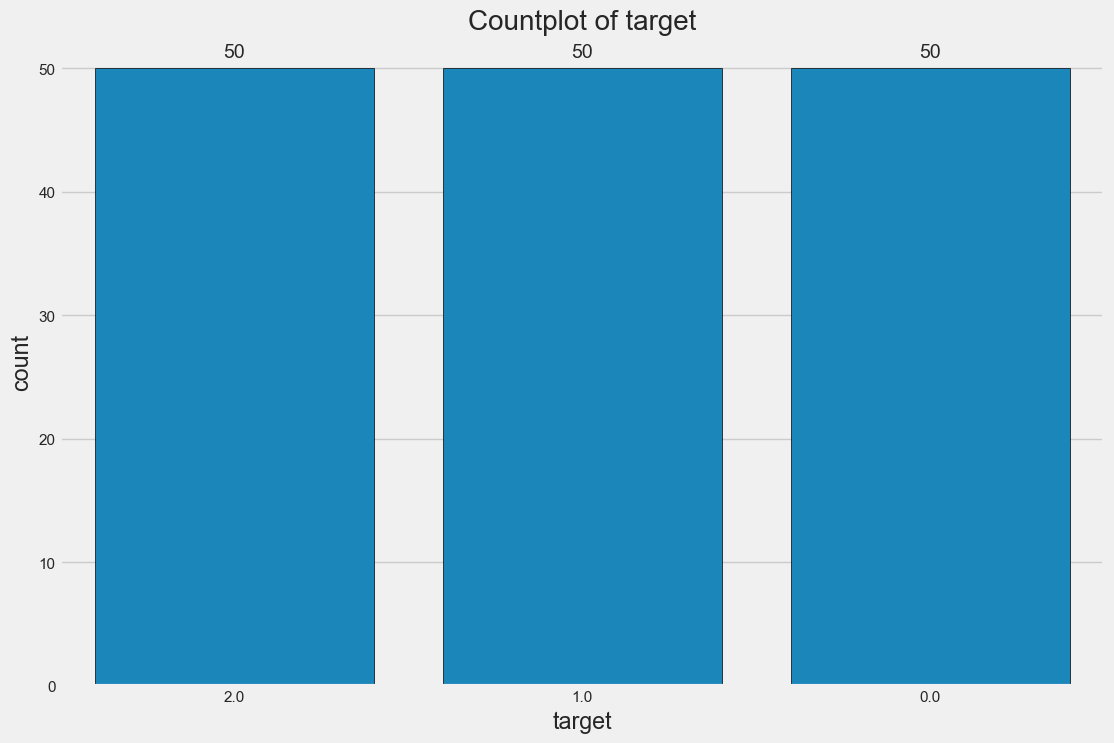

In [73]:
fast_eda(iris, target = 'target')

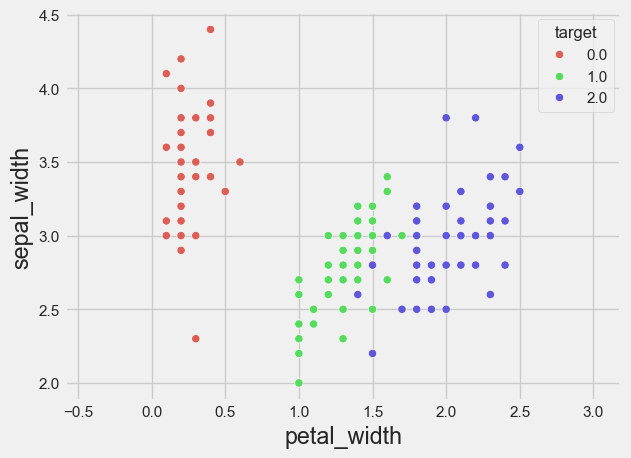

In [74]:
plt.axis('equal')
sns.scatterplot(iris, x='petal_width', y='sepal_width', hue='target', palette=sns.color_palette("hls", iris['target'].nunique()))
plt.show()

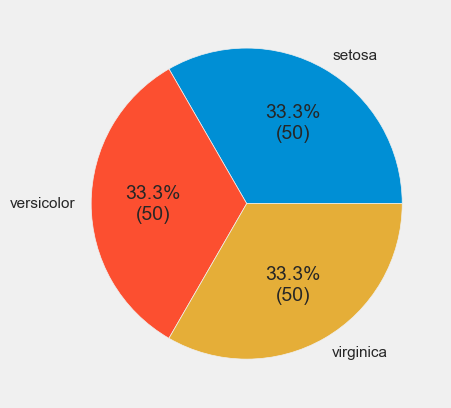

In [75]:
# Define a function to format value counts into percentages
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

# Get value counts
vc = iris['target'].value_counts()

# Draw a pie chart using value counts and the `autopct_format` format
_ = plt.pie(vc, labels = vc.rename(class_names).index, autopct=autopct_format(vc))